In [1]:
import os
import nibabel as nib
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn.utils.parametrize as parametrize
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [3]:
data_dir = './Dataset'
print(os.listdir(data_dir))

img_dir = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]
imgs = [nib.load(img_dir[i]) for i in [0,1,2,5]]
imgs_data = [torch.tensor(i.get_fdata()).unsqueeze(0) for i in imgs]

['I269254_I989324imagedata.nii.gz', 'I269254_I1304069imagedata.nii.gz', 'I269254_I1501115imagedata.nii.gz', 'I269254_I1241097imagedataLMCI.nii.gz', 'I269254_I235238imagedataLMCI.nii.gz', 'I269254_I1132801imagedata.nii.gz']


In [4]:
random_seed = 20220509
torch.manual_seed(random_seed);

In [5]:
def Data_Normalization(imgs_data):
    max_value = []
    min_value = []
    for img in imgs_data:
        max_value.append(torch.max(img))
        min_value.append(torch.min(img))
    imgs_data = [2*((x-mi)/(ma-mi)-0.5) for x, ma, mi in zip(imgs_data, max_value, min_value)]
    return imgs_data, max_value, min_value

In [6]:
imgs_data, max_value, min_value = Data_Normalization(imgs_data)

Create my own dataset:

In [7]:
# # In order to assign 'labels' to data
# import os
# import pandas as pd
# from torchvision.io import read_image

# class CustomImageDataset(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         self.img_labels = pd.read_csv(annotations_file)
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [8]:
# imgs_to_be_plotted = imgs_data[0][imgs_data[0].bool()]
# hist = torch.histc(imgs_to_be_plotted, bins=2, min=-1, max=1)
# x = range(2)
# plt.bar(x, hist, align='center', color=['forestgreen'])
# plt.xlabel('Bins')
# plt.ylabel('Frequency')
# plt.show()

In [9]:
# imgs_to_be_plotted = imgs_data[0][imgs_data[0].bool()]
# hist = torch.histc(imgs_to_be_plotted, bins=2000, min=250, max=2200)
# x = range(2000)
# plt.bar(x, hist, align='center', color=['forestgreen'])
# plt.xlabel('Bins')
# plt.ylabel('Frequency')
# plt.show()

In [10]:
# for s in range(len(imgs_data)):
#     for t in range(imgs_data[s].size(-1)):
#         imgs_data[s][:,:,:,:,t] = T.Normalize(1000, 1000)(imgs_data[s][:,:,:,:,t])

In [7]:
imgs_data[2].shape

torch.Size([1, 91, 109, 91, 177])

In [11]:
val_size = 0
train_size = len(imgs) - val_size

# train_ds, val_ds = random_split(imgs_data, [train_size, val_size])
train_ds = imgs_data

Helper functions for using GPU

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True, dtype=torch.float)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now create PyTorch data loaders for training and validation.

In [9]:
batch_size = 4

train_loader = DataLoader(train_ds, batch_size)
# val_loader = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory = True)

# move to GPU
device = get_default_device()
print(device)
train_loader = DeviceDataLoader(train_loader, device)
# val_loader = DeviceDataLoader(val_loader, device)

cuda


Next is the model

In [10]:
class FrobeniusNormalization(nn.Module):
    def forward(self, X):
        F_norm = torch.linalg.matrix_norm(X).item()
        return(torch.div(X, F_norm))

In [11]:
class RecVAEModel(nn.Module):
    def __init__(self, enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.):
        super().__init__()
        
        self.sqr_sig_x = sqr_sig_x
        self.sqr_sig_h = sqr_sig_h
        # Encoder: from input(x) to one of the inputs of the hidden layer (enc_x)
        # input: 1 x 91 x 109 x 91
        self.encoder1 = nn.Sequential(
            nn.Conv3d(1, 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.2, inplace = True)) # output: 4 x 45 x 54 x 45
        
        self.encoder2 = nn.Sequential(
            nn.Conv3d(4, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.2, inplace = True)) # output: 8 x 22 x 27 x 22
        
        self.encoder3 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(0.2, inplace = True)) # output: 16 x 11 x 13 x 11
        
        self.encoder4 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace = True)) # output: 32 x 5 x 6 x 5
        
        self.encoder5 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(32*5*6*5, enc_out_dim),
            nn.Tanh()) # output: enc_out_dim
        
        
        # Hidden: from (enc_x,h_{t-1}) to h_t
        self.hidden2mu = nn.Linear(enc_out_dim+latent_dim, latent_dim)
        self.hidden2log_var = nn.Linear(enc_out_dim+latent_dim, latent_dim)
        
        # Decoder: from h_t to mu_t
        self.decoder1 = nn.Sequential(
            nn.Linear(latent_dim, 32*5*6*5),
            nn.Unflatten(1, (32, 5, 6, 5)),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.2, inplace = True))
          
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), 
            nn.BatchNorm3d(16),
            nn.LeakyReLU(0.2, inplace = True))
        
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose3d(16, 8, kernel_size=4, stride=2, padding=1, output_padding=(0,1,0), bias=False), 
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.2, inplace = True))
        
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose3d(8, 4, kernel_size=4, stride=2, padding=1, output_padding=(1,0,1), bias=False), 
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.2, inplace = True))
        
        self.decoder5 = nn.Sequential(
            nn.ConvTranspose3d(4, 1, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False), 
            nn.Tanh())
                   
            
#         self.decoder1 = nn.Sequential(
#             nn.Linear(latent_dim, 200),
#             nn.ReLU(True))
        
#         self.decoder2 = nn.Sequential(
#             nn.Linear(200, 200),
#             nn.ReLU(True))
        
#         self.decoder3 = nn.Sequential(
#             nn.Linear(200, 200),
#             nn.ReLU(True))
        
#         self.decoder4 = nn.Sequential(
#             nn.Linear(200, 1*91*109*91),
#             nn.Tanh(),
#             nn.Unflatten(1, (1, 91, 109, 91))) # output: 1 x 91 x 109 x 91
        
        
        # g(h_{t-1})
        self.g_transform1 = nn.Linear(latent_dim, 128)
        parametrize.register_parametrization(self.g_transform1, "weight", FrobeniusNormalization())
        
        self.g_transform2 = nn.Linear(128, 128)
        parametrize.register_parametrization(self.g_transform2, "weight", FrobeniusNormalization())
        
        self.g_transform3 = nn.Linear(128, latent_dim)
        parametrize.register_parametrization(self.g_transform3, "weight", FrobeniusNormalization())
        
       
    def g_transform(self, h_old):
        h_new = self.g_transform1(h_old)
        h_new = F.relu(h_new)
        h_new = self.g_transform2(h_new)
        h_new = F.relu(h_new)
        h_new = self.g_transform3(h_new)
        return h_new
     
    
    def encode(self, x):
        enc_x = self.encoder1(x)
        enc_x = self.encoder2(enc_x)
        enc_x = self.encoder3(enc_x)
        enc_x = self.encoder4(enc_x)
        enc_x = self.encoder5(enc_x)
        return enc_x
    
    
    def decode(self, h):
        dec_h = self.decoder1(h)
        dec_h = self.decoder2(dec_h)
        dec_h = self.decoder3(dec_h)
        dec_h = self.decoder4(dec_h)
        dec_h = self.decoder5(dec_h)
        return dec_h
        
    
    def reparametrize(self, mu_h,log_var_h):
        # Reparametrization Trick to allow gradients to backpropagate from the stochastic part of the model
        sigma_h = torch.exp(log_var_h / 2)
        z = torch.randn(size = (mu_h.size(0),mu_h.size(1)))
        z = z.type_as(mu_h) # Setting z to be .cuda when using GPU training
        return mu_h + sigma_h*z
      
    
    def VAE(self, x, h):   
        # encode x and h to get the mu and variance parameters for the latent space
        enc_x = self.encode(x)
        combined = torch.cat((enc_x, h), 1)
        mu_h, log_var_h = self.hidden2mu(combined), self.hidden2log_var(combined)
        
        # sample h
        h = self.reparametrize(mu_h, log_var_h)
        
        # decode  
        mu = self.decode(h)
        return mu, h
    
    
    def training_step(self, batch, h):
        '''h is h_0. It is of size batch_size*latent_dim'''
        batch = batch.to(torch.float32)
        x_list, mu_history, h_history, gh_history = self(batch, h)
        
        temp = 2 * batch_size * len(h_history)
        # calculate loss
        loss1 = sum([torch.sum(torch.pow(x-mu, 2)) for x, mu in zip(x_list, mu_history)])
        loss1 = loss1 / self.sqr_sig_x / temp
        #loss1 = sum([F.mse_loss(x, mu) for x, mu in zip(x_list, mu_history)])
#         loss2 = sum([torch.sum(torch.pow(h-gh, 2)) for h, gh in zip(h_history, gh_history)])
#         loss2 = loss2 / self.sqr_sig_h / temp
        loss2 = 0
#         for h, gh in zip(h_history, gh_history):
#             print(h, gh)
#             #print(torch.isnan(h).any(), torch.isnan(gh).any())
        #loss2 = sum([F.mse_loss(h, gh) for h, gh in zip(h_history, gh_history)])
        #print(loss1, loss2)
        loss = loss1 + loss2
        
        return loss1, loss2, loss
    
    
    def forward(self, x, h):
        tol_time = x.size(-1) # x is of size batch_size*channel*x1*x2*x3*tol_time
        x_list = [x[:,:,:,:,:,t] for t in range(tol_time)]
        h_history = []
        gh_history = []
        mu_history = []
        for t in range(tol_time):
            #print(t)
            gh_history.append(self.g_transform(h))
            mu, h = self.VAE(x_list[t], h)
            h_history.append(h)
            mu_history.append(mu)
        # print("h: ", h_history[50], "\n", "gh: ", gh_history[50])
        return x_list, mu_history, h_history, gh_history
    

model = RecVAEModel()
model = to_device(model, device)

In [12]:
def fit(epochs, lr, h0, model, train_loader=train_loader, val_loader=val_loader, opt_func=torch.optim.SGD):
    train_loss_history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        for batch in train_loader:
            loss1, loss2, loss = model.training_step(batch, h0.expand(batch.size(0), -1))
            #print(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # train_loss_history.append(loss)
        # print("Epoch [{}], train_loss: {:.2f}".format(epoch, loss))
        print("Epoch [{}], train_loss: {:.2f} with loss1: {:.2f} and loss2: {:.2f}".format(epoch, loss, loss1, loss2))
    return train_loss_history

In [13]:
h0 = torch.rand(1, 50)
h0 = to_device(h0, device)
h0

tensor([[0.1588, 0.9874, 0.0306, 0.6957, 0.7576, 0.4175, 0.7801, 0.2534, 0.1590,
         0.6342, 0.1621, 0.6749, 0.7424, 0.6826, 0.7230, 0.4097, 0.3554, 0.9870,
         0.8070, 0.4136, 0.7174, 0.0706, 0.4964, 0.5325, 0.1997, 0.5332, 0.7564,
         0.5999, 0.9894, 0.3375, 0.0979, 0.0249, 0.4479, 0.2737, 0.2277, 0.1193,
         0.9575, 0.5872, 0.2907, 0.7241, 0.6682, 0.0566, 0.3019, 0.8464, 0.0608,
         0.0999, 0.3458, 0.9315, 0.5250, 0.3600]], device='cuda:0')

New decoder

In [22]:
# enc_out_dim=200, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=1e-6, h0=h0, model=model)

Epoch [0], train_loss: 194742.62 with loss1: 194742.62 and loss2: 0.00
Epoch [1], train_loss: 104011.70 with loss1: 104011.70 and loss2: 0.00
Epoch [2], train_loss: 80626.57 with loss1: 80626.57 and loss2: 0.00
Epoch [3], train_loss: 69839.09 with loss1: 69839.09 and loss2: 0.00
Epoch [4], train_loss: 58970.20 with loss1: 58970.20 and loss2: 0.00
Epoch [5], train_loss: 54786.08 with loss1: 54786.08 and loss2: 0.00
Epoch [6], train_loss: 58546.38 with loss1: 58546.38 and loss2: 0.00
Epoch [7], train_loss: 53538.83 with loss1: 53538.83 and loss2: 0.00
Epoch [8], train_loss: 48686.29 with loss1: 48686.29 and loss2: 0.00
Epoch [9], train_loss: 51127.53 with loss1: 51127.53 and loss2: 0.00
Epoch [10], train_loss: 48807.86 with loss1: 48807.86 and loss2: 0.00
Epoch [11], train_loss: 41193.52 with loss1: 41193.52 and loss2: 0.00
Epoch [12], train_loss: 43514.22 with loss1: 43514.22 and loss2: 0.00
Epoch [13], train_loss: 40934.07 with loss1: 40934.07 and loss2: 0.00
Epoch [14], train_loss: 38

Epoch [119], train_loss: 6989.63 with loss1: 6989.63 and loss2: 0.00
Epoch [120], train_loss: 6976.28 with loss1: 6976.28 and loss2: 0.00
Epoch [121], train_loss: 7180.56 with loss1: 7180.56 and loss2: 0.00
Epoch [122], train_loss: 6838.21 with loss1: 6838.21 and loss2: 0.00
Epoch [123], train_loss: 7150.52 with loss1: 7150.52 and loss2: 0.00
Epoch [124], train_loss: 7097.39 with loss1: 7097.39 and loss2: 0.00
Epoch [125], train_loss: 6617.31 with loss1: 6617.31 and loss2: 0.00
Epoch [126], train_loss: 6398.66 with loss1: 6398.66 and loss2: 0.00
Epoch [127], train_loss: 6778.54 with loss1: 6778.54 and loss2: 0.00
Epoch [128], train_loss: 6379.75 with loss1: 6379.75 and loss2: 0.00
Epoch [129], train_loss: 6341.45 with loss1: 6341.45 and loss2: 0.00
Epoch [130], train_loss: 7607.26 with loss1: 7607.26 and loss2: 0.00
Epoch [131], train_loss: 6340.53 with loss1: 6340.53 and loss2: 0.00
Epoch [132], train_loss: 6514.80 with loss1: 6514.80 and loss2: 0.00
Epoch [133], train_loss: 6753.79 w

Epoch [238], train_loss: 6887.66 with loss1: 6887.66 and loss2: 0.00
Epoch [239], train_loss: 6725.36 with loss1: 6725.36 and loss2: 0.00
Epoch [240], train_loss: 6113.94 with loss1: 6113.94 and loss2: 0.00
Epoch [241], train_loss: 5772.13 with loss1: 5772.13 and loss2: 0.00
Epoch [242], train_loss: 5997.25 with loss1: 5997.25 and loss2: 0.00
Epoch [243], train_loss: 6848.79 with loss1: 6848.79 and loss2: 0.00
Epoch [244], train_loss: 6185.34 with loss1: 6185.34 and loss2: 0.00
Epoch [245], train_loss: 6069.22 with loss1: 6069.22 and loss2: 0.00
Epoch [246], train_loss: 5953.27 with loss1: 5953.27 and loss2: 0.00
Epoch [247], train_loss: 6846.04 with loss1: 6846.04 and loss2: 0.00
Epoch [248], train_loss: 6065.34 with loss1: 6065.34 and loss2: 0.00
Epoch [249], train_loss: 5525.98 with loss1: 5525.98 and loss2: 0.00
Epoch [250], train_loss: 6198.79 with loss1: 6198.79 and loss2: 0.00
Epoch [251], train_loss: 5710.17 with loss1: 5710.17 and loss2: 0.00
Epoch [252], train_loss: 6035.80 w

Epoch [357], train_loss: 6200.45 with loss1: 6200.45 and loss2: 0.00
Epoch [358], train_loss: 6102.05 with loss1: 6102.05 and loss2: 0.00
Epoch [359], train_loss: 5853.05 with loss1: 5853.05 and loss2: 0.00
Epoch [360], train_loss: 5593.33 with loss1: 5593.33 and loss2: 0.00
Epoch [361], train_loss: 5455.84 with loss1: 5455.84 and loss2: 0.00
Epoch [362], train_loss: 4957.16 with loss1: 4957.16 and loss2: 0.00
Epoch [363], train_loss: 6151.73 with loss1: 6151.73 and loss2: 0.00
Epoch [364], train_loss: 5132.87 with loss1: 5132.87 and loss2: 0.00
Epoch [365], train_loss: 5127.86 with loss1: 5127.86 and loss2: 0.00
Epoch [366], train_loss: 5112.59 with loss1: 5112.59 and loss2: 0.00
Epoch [367], train_loss: 5453.71 with loss1: 5453.71 and loss2: 0.00
Epoch [368], train_loss: 5553.46 with loss1: 5553.46 and loss2: 0.00
Epoch [369], train_loss: 5129.71 with loss1: 5129.71 and loss2: 0.00
Epoch [370], train_loss: 5098.52 with loss1: 5098.52 and loss2: 0.00
Epoch [371], train_loss: 6052.64 w

Epoch [476], train_loss: 4584.70 with loss1: 4584.70 and loss2: 0.00
Epoch [477], train_loss: 4335.53 with loss1: 4335.53 and loss2: 0.00
Epoch [478], train_loss: 4567.22 with loss1: 4567.22 and loss2: 0.00
Epoch [479], train_loss: 4309.35 with loss1: 4309.35 and loss2: 0.00
Epoch [480], train_loss: 4892.52 with loss1: 4892.52 and loss2: 0.00
Epoch [481], train_loss: 5392.86 with loss1: 5392.86 and loss2: 0.00
Epoch [482], train_loss: 5607.52 with loss1: 5607.52 and loss2: 0.00
Epoch [483], train_loss: 4563.71 with loss1: 4563.71 and loss2: 0.00
Epoch [484], train_loss: 5370.04 with loss1: 5370.04 and loss2: 0.00
Epoch [485], train_loss: 4294.14 with loss1: 4294.14 and loss2: 0.00
Epoch [486], train_loss: 5623.77 with loss1: 5623.77 and loss2: 0.00
Epoch [487], train_loss: 4547.22 with loss1: 4547.22 and loss2: 0.00
Epoch [488], train_loss: 4301.48 with loss1: 4301.48 and loss2: 0.00
Epoch [489], train_loss: 4870.01 with loss1: 4870.01 and loss2: 0.00
Epoch [490], train_loss: 5636.11 w

In [24]:
# continued
# enc_out_dim=200, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=5e-5, h0=h0, model=model)

Epoch [0], train_loss: 26639.27 with loss1: 26639.27 and loss2: 0.00
Epoch [1], train_loss: 99967.50 with loss1: 99967.50 and loss2: 0.00
Epoch [2], train_loss: 90690.41 with loss1: 90690.41 and loss2: 0.00
Epoch [3], train_loss: 90513.84 with loss1: 90513.84 and loss2: 0.00
Epoch [4], train_loss: 96516.62 with loss1: 96516.62 and loss2: 0.00
Epoch [5], train_loss: 99967.50 with loss1: 99967.50 and loss2: 0.00
Epoch [6], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [7], train_loss: 90513.84 with loss1: 90513.84 and loss2: 0.00
Epoch [8], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [9], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [10], train_loss: 105970.28 with loss1: 105970.28 and loss2: 0.00
Epoch [11], train_loss: 90513.84 with loss1: 90513.84 and loss2: 0.00
Epoch [12], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [13], train_loss: 105793.66 with loss1: 105793.66 and loss2: 0.00
Epoch [14], train_

KeyboardInterrupt: 

In [27]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 99433.16 with loss1: 99433.16 and loss2: 0.00
Epoch [1], train_loss: 59789.14 with loss1: 59789.14 and loss2: 0.00
Epoch [2], train_loss: 58515.09 with loss1: 58515.09 and loss2: 0.00
Epoch [3], train_loss: 47473.84 with loss1: 47473.84 and loss2: 0.00
Epoch [4], train_loss: 45237.55 with loss1: 45237.55 and loss2: 0.00
Epoch [5], train_loss: 36444.26 with loss1: 36444.26 and loss2: 0.00
Epoch [6], train_loss: 27717.99 with loss1: 27717.99 and loss2: 0.00
Epoch [7], train_loss: 18050.49 with loss1: 18050.49 and loss2: 0.00
Epoch [8], train_loss: 21614.59 with loss1: 21614.59 and loss2: 0.00
Epoch [9], train_loss: 13650.98 with loss1: 13650.98 and loss2: 0.00
Epoch [10], train_loss: 10935.08 with loss1: 10935.08 and loss2: 0.00
Epoch [11], train_loss: 11332.80 with loss1: 11332.80 and loss2: 0.00
Epoch [12], train_loss: 9497.66 with loss1: 9497.66 and loss2: 0.00
Epoch [13], train_loss: 9187.84 with loss1: 9187.84 and loss2: 0.00
Epoch [14], train_loss: 8991.74 wi

Epoch [120], train_loss: 6037.15 with loss1: 6037.15 and loss2: 0.00
Epoch [121], train_loss: 7012.71 with loss1: 7012.71 and loss2: 0.00
Epoch [122], train_loss: 5950.04 with loss1: 5950.04 and loss2: 0.00
Epoch [123], train_loss: 5759.92 with loss1: 5759.92 and loss2: 0.00
Epoch [124], train_loss: 5950.07 with loss1: 5950.07 and loss2: 0.00
Epoch [125], train_loss: 5730.65 with loss1: 5730.65 and loss2: 0.00
Epoch [126], train_loss: 5683.56 with loss1: 5683.56 and loss2: 0.00
Epoch [127], train_loss: 7233.43 with loss1: 7233.43 and loss2: 0.00
Epoch [128], train_loss: 5954.90 with loss1: 5954.90 and loss2: 0.00
Epoch [129], train_loss: 5735.08 with loss1: 5735.08 and loss2: 0.00
Epoch [130], train_loss: 5556.94 with loss1: 5556.94 and loss2: 0.00
Epoch [131], train_loss: 6010.86 with loss1: 6010.86 and loss2: 0.00
Epoch [132], train_loss: 7252.82 with loss1: 7252.82 and loss2: 0.00
Epoch [133], train_loss: 5574.28 with loss1: 5574.28 and loss2: 0.00
Epoch [134], train_loss: 5974.77 w

Epoch [239], train_loss: 5257.14 with loss1: 5257.14 and loss2: 0.00
Epoch [240], train_loss: 5024.77 with loss1: 5024.77 and loss2: 0.00
Epoch [241], train_loss: 6501.08 with loss1: 6501.08 and loss2: 0.00
Epoch [242], train_loss: 5458.52 with loss1: 5458.52 and loss2: 0.00
Epoch [243], train_loss: 5782.76 with loss1: 5782.76 and loss2: 0.00
Epoch [244], train_loss: 6131.38 with loss1: 6131.38 and loss2: 0.00
Epoch [245], train_loss: 5551.84 with loss1: 5551.84 and loss2: 0.00
Epoch [246], train_loss: 6363.19 with loss1: 6363.19 and loss2: 0.00
Epoch [247], train_loss: 6468.12 with loss1: 6468.12 and loss2: 0.00
Epoch [248], train_loss: 5197.91 with loss1: 5197.91 and loss2: 0.00
Epoch [249], train_loss: 5493.80 with loss1: 5493.80 and loss2: 0.00
Epoch [250], train_loss: 5896.02 with loss1: 5896.02 and loss2: 0.00
Epoch [251], train_loss: 6144.61 with loss1: 6144.61 and loss2: 0.00
Epoch [252], train_loss: 5387.96 with loss1: 5387.96 and loss2: 0.00
Epoch [253], train_loss: 5395.56 w

Epoch [358], train_loss: 4299.65 with loss1: 4299.65 and loss2: 0.00
Epoch [359], train_loss: 5211.18 with loss1: 5211.18 and loss2: 0.00
Epoch [360], train_loss: 3884.29 with loss1: 3884.29 and loss2: 0.00
Epoch [361], train_loss: 4471.90 with loss1: 4471.90 and loss2: 0.00
Epoch [362], train_loss: 4848.57 with loss1: 4848.57 and loss2: 0.00
Epoch [363], train_loss: 4696.26 with loss1: 4696.26 and loss2: 0.00
Epoch [364], train_loss: 5167.29 with loss1: 5167.29 and loss2: 0.00
Epoch [365], train_loss: 4316.56 with loss1: 4316.56 and loss2: 0.00
Epoch [366], train_loss: 5162.63 with loss1: 5162.63 and loss2: 0.00
Epoch [367], train_loss: 5268.40 with loss1: 5268.40 and loss2: 0.00
Epoch [368], train_loss: 4255.43 with loss1: 4255.43 and loss2: 0.00
Epoch [369], train_loss: 4102.75 with loss1: 4102.75 and loss2: 0.00
Epoch [370], train_loss: 3822.71 with loss1: 3822.71 and loss2: 0.00
Epoch [371], train_loss: 5194.83 with loss1: 5194.83 and loss2: 0.00
Epoch [372], train_loss: 5234.47 w

Epoch [477], train_loss: 4198.28 with loss1: 4198.28 and loss2: 0.00
Epoch [478], train_loss: 4199.22 with loss1: 4199.22 and loss2: 0.00
Epoch [479], train_loss: 4201.58 with loss1: 4201.58 and loss2: 0.00
Epoch [480], train_loss: 4249.04 with loss1: 4249.04 and loss2: 0.00
Epoch [481], train_loss: 5003.00 with loss1: 5003.00 and loss2: 0.00
Epoch [482], train_loss: 3871.00 with loss1: 3871.00 and loss2: 0.00
Epoch [483], train_loss: 4092.38 with loss1: 4092.38 and loss2: 0.00
Epoch [484], train_loss: 4383.12 with loss1: 4383.12 and loss2: 0.00
Epoch [485], train_loss: 4357.51 with loss1: 4357.51 and loss2: 0.00
Epoch [486], train_loss: 4233.48 with loss1: 4233.48 and loss2: 0.00
Epoch [487], train_loss: 4185.08 with loss1: 4185.08 and loss2: 0.00
Epoch [488], train_loss: 4152.99 with loss1: 4152.99 and loss2: 0.00
Epoch [489], train_loss: 4154.94 with loss1: 4154.94 and loss2: 0.00
Epoch [490], train_loss: 4291.90 with loss1: 4291.90 and loss2: 0.00
Epoch [491], train_loss: 4172.88 w

Epoch [596], train_loss: 3458.61 with loss1: 3458.61 and loss2: 0.00
Epoch [597], train_loss: 3906.37 with loss1: 3906.37 and loss2: 0.00
Epoch [598], train_loss: 4019.28 with loss1: 4019.28 and loss2: 0.00
Epoch [599], train_loss: 2959.14 with loss1: 2959.14 and loss2: 0.00
Epoch [600], train_loss: 3466.25 with loss1: 3466.25 and loss2: 0.00
Epoch [601], train_loss: 4594.80 with loss1: 4594.80 and loss2: 0.00
Epoch [602], train_loss: 3929.01 with loss1: 3929.01 and loss2: 0.00
Epoch [603], train_loss: 2985.33 with loss1: 2985.33 and loss2: 0.00
Epoch [604], train_loss: 4549.44 with loss1: 4549.44 and loss2: 0.00
Epoch [605], train_loss: 3906.88 with loss1: 3906.88 and loss2: 0.00
Epoch [606], train_loss: 3552.94 with loss1: 3552.94 and loss2: 0.00
Epoch [607], train_loss: 3777.13 with loss1: 3777.13 and loss2: 0.00
Epoch [608], train_loss: 4514.67 with loss1: 4514.67 and loss2: 0.00
Epoch [609], train_loss: 3007.01 with loss1: 3007.01 and loss2: 0.00
Epoch [610], train_loss: 4547.23 w

Epoch [715], train_loss: 3770.91 with loss1: 3770.91 and loss2: 0.00
Epoch [716], train_loss: 3739.85 with loss1: 3739.85 and loss2: 0.00
Epoch [717], train_loss: 4461.04 with loss1: 4461.04 and loss2: 0.00
Epoch [718], train_loss: 4085.34 with loss1: 4085.34 and loss2: 0.00
Epoch [719], train_loss: 4481.47 with loss1: 4481.47 and loss2: 0.00
Epoch [720], train_loss: 4424.89 with loss1: 4424.89 and loss2: 0.00
Epoch [721], train_loss: 3352.10 with loss1: 3352.10 and loss2: 0.00
Epoch [722], train_loss: 4349.88 with loss1: 4349.88 and loss2: 0.00
Epoch [723], train_loss: 4397.84 with loss1: 4397.84 and loss2: 0.00
Epoch [724], train_loss: 4399.01 with loss1: 4399.01 and loss2: 0.00
Epoch [725], train_loss: 3979.67 with loss1: 3979.67 and loss2: 0.00
Epoch [726], train_loss: 4420.32 with loss1: 4420.32 and loss2: 0.00
Epoch [727], train_loss: 3927.66 with loss1: 3927.66 and loss2: 0.00
Epoch [728], train_loss: 3772.59 with loss1: 3772.59 and loss2: 0.00
Epoch [729], train_loss: 4397.68 w

Epoch [834], train_loss: 4323.46 with loss1: 4323.46 and loss2: 0.00
Epoch [835], train_loss: 3902.28 with loss1: 3902.28 and loss2: 0.00
Epoch [836], train_loss: 4351.94 with loss1: 4351.94 and loss2: 0.00
Epoch [837], train_loss: 4285.20 with loss1: 4285.20 and loss2: 0.00
Epoch [838], train_loss: 3635.16 with loss1: 3635.16 and loss2: 0.00
Epoch [839], train_loss: 3202.06 with loss1: 3202.06 and loss2: 0.00
Epoch [840], train_loss: 2711.59 with loss1: 2711.59 and loss2: 0.00
Epoch [841], train_loss: 2659.58 with loss1: 2659.58 and loss2: 0.00
Epoch [842], train_loss: 2630.59 with loss1: 2630.59 and loss2: 0.00
Epoch [843], train_loss: 3275.29 with loss1: 3275.29 and loss2: 0.00
Epoch [844], train_loss: 3310.98 with loss1: 3310.98 and loss2: 0.00
Epoch [845], train_loss: 3208.11 with loss1: 3208.11 and loss2: 0.00
Epoch [846], train_loss: 3264.45 with loss1: 3264.45 and loss2: 0.00
Epoch [847], train_loss: 4220.92 with loss1: 4220.92 and loss2: 0.00
Epoch [848], train_loss: 2621.07 w

Epoch [953], train_loss: 3296.86 with loss1: 3296.86 and loss2: 0.00
Epoch [954], train_loss: 2601.20 with loss1: 2601.20 and loss2: 0.00
Epoch [955], train_loss: 3473.50 with loss1: 3473.50 and loss2: 0.00
Epoch [956], train_loss: 3123.09 with loss1: 3123.09 and loss2: 0.00
Epoch [957], train_loss: 3230.76 with loss1: 3230.76 and loss2: 0.00
Epoch [958], train_loss: 2781.26 with loss1: 2781.26 and loss2: 0.00
Epoch [959], train_loss: 3486.60 with loss1: 3486.60 and loss2: 0.00
Epoch [960], train_loss: 3644.07 with loss1: 3644.07 and loss2: 0.00
Epoch [961], train_loss: 3679.50 with loss1: 3679.50 and loss2: 0.00
Epoch [962], train_loss: 4220.29 with loss1: 4220.29 and loss2: 0.00
Epoch [963], train_loss: 3559.68 with loss1: 3559.68 and loss2: 0.00
Epoch [964], train_loss: 3740.39 with loss1: 3740.39 and loss2: 0.00
Epoch [965], train_loss: 3552.41 with loss1: 3552.41 and loss2: 0.00
Epoch [966], train_loss: 3083.21 with loss1: 3083.21 and loss2: 0.00
Epoch [967], train_loss: 3476.91 w

In [ ]:
# enc_out_dim=100, latent_dim=100, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 82938.25 with loss1: 82938.25 and loss2: 0.00
Epoch [1], train_loss: 59790.07 with loss1: 59790.07 and loss2: 0.00
Epoch [2], train_loss: 56011.70 with loss1: 56011.70 and loss2: 0.00
Epoch [3], train_loss: 49071.40 with loss1: 49071.40 and loss2: 0.00
Epoch [4], train_loss: 32797.59 with loss1: 32797.59 and loss2: 0.00
Epoch [5], train_loss: 24859.16 with loss1: 24859.16 and loss2: 0.00
Epoch [6], train_loss: 22937.26 with loss1: 22937.26 and loss2: 0.00
Epoch [7], train_loss: 12778.61 with loss1: 12778.61 and loss2: 0.00
Epoch [8], train_loss: 12235.31 with loss1: 12235.31 and loss2: 0.00
Epoch [9], train_loss: 11393.92 with loss1: 11393.92 and loss2: 0.00
Epoch [10], train_loss: 10219.99 with loss1: 10219.99 and loss2: 0.00
Epoch [11], train_loss: 10087.34 with loss1: 10087.34 and loss2: 0.00
Epoch [12], train_loss: 9793.68 with loss1: 9793.68 and loss2: 0.00
Epoch [13], train_loss: 9259.64 with loss1: 9259.64 and loss2: 0.00
Epoch [14], train_loss: 9932.75 wi

Epoch [120], train_loss: 5817.48 with loss1: 5817.48 and loss2: 0.00
Epoch [121], train_loss: 5825.54 with loss1: 5825.54 and loss2: 0.00
Epoch [122], train_loss: 6092.05 with loss1: 6092.05 and loss2: 0.00
Epoch [123], train_loss: 5954.06 with loss1: 5954.06 and loss2: 0.00
Epoch [124], train_loss: 7226.69 with loss1: 7226.69 and loss2: 0.00
Epoch [125], train_loss: 5900.05 with loss1: 5900.05 and loss2: 0.00
Epoch [126], train_loss: 5713.09 with loss1: 5713.09 and loss2: 0.00
Epoch [127], train_loss: 5800.07 with loss1: 5800.07 and loss2: 0.00
Epoch [128], train_loss: 5622.43 with loss1: 5622.43 and loss2: 0.00
Epoch [129], train_loss: 5689.13 with loss1: 5689.13 and loss2: 0.00
Epoch [130], train_loss: 7212.95 with loss1: 7212.95 and loss2: 0.00
Epoch [131], train_loss: 5988.74 with loss1: 5988.74 and loss2: 0.00
Epoch [132], train_loss: 5752.96 with loss1: 5752.96 and loss2: 0.00
Epoch [133], train_loss: 5707.03 with loss1: 5707.03 and loss2: 0.00
Epoch [134], train_loss: 6967.09 w

Epoch [239], train_loss: 5779.59 with loss1: 5779.59 and loss2: 0.00
Epoch [240], train_loss: 5479.03 with loss1: 5479.03 and loss2: 0.00
Epoch [241], train_loss: 5530.39 with loss1: 5530.39 and loss2: 0.00
Epoch [242], train_loss: 5447.96 with loss1: 5447.96 and loss2: 0.00
Epoch [243], train_loss: 5281.57 with loss1: 5281.57 and loss2: 0.00
Epoch [244], train_loss: 5723.83 with loss1: 5723.83 and loss2: 0.00
Epoch [245], train_loss: 6392.44 with loss1: 6392.44 and loss2: 0.00
Epoch [246], train_loss: 5572.52 with loss1: 5572.52 and loss2: 0.00
Epoch [247], train_loss: 5473.90 with loss1: 5473.90 and loss2: 0.00
Epoch [248], train_loss: 5440.16 with loss1: 5440.16 and loss2: 0.00
Epoch [249], train_loss: 5581.73 with loss1: 5581.73 and loss2: 0.00
Epoch [250], train_loss: 6383.41 with loss1: 6383.41 and loss2: 0.00
Epoch [251], train_loss: 6544.18 with loss1: 6544.18 and loss2: 0.00
Epoch [252], train_loss: 5538.41 with loss1: 5538.41 and loss2: 0.00
Epoch [253], train_loss: 5625.55 w

Epoch [358], train_loss: 5055.15 with loss1: 5055.15 and loss2: 0.00
Epoch [359], train_loss: 5334.35 with loss1: 5334.35 and loss2: 0.00
Epoch [360], train_loss: 5472.51 with loss1: 5472.51 and loss2: 0.00
Epoch [361], train_loss: 5281.90 with loss1: 5281.90 and loss2: 0.00
Epoch [362], train_loss: 5225.04 with loss1: 5225.04 and loss2: 0.00
Epoch [363], train_loss: 5149.39 with loss1: 5149.39 and loss2: 0.00
Epoch [364], train_loss: 5468.02 with loss1: 5468.02 and loss2: 0.00
Epoch [365], train_loss: 5195.13 with loss1: 5195.13 and loss2: 0.00
Epoch [366], train_loss: 5335.48 with loss1: 5335.48 and loss2: 0.00
Epoch [367], train_loss: 5250.24 with loss1: 5250.24 and loss2: 0.00
Epoch [368], train_loss: 5439.14 with loss1: 5439.14 and loss2: 0.00
Epoch [369], train_loss: 5255.84 with loss1: 5255.84 and loss2: 0.00
Epoch [370], train_loss: 6424.66 with loss1: 6424.66 and loss2: 0.00
Epoch [371], train_loss: 5266.40 with loss1: 5266.40 and loss2: 0.00
Epoch [372], train_loss: 5233.40 w

Epoch [477], train_loss: 4853.61 with loss1: 4853.61 and loss2: 0.00
Epoch [478], train_loss: 6230.73 with loss1: 6230.73 and loss2: 0.00
Epoch [479], train_loss: 5167.80 with loss1: 5167.80 and loss2: 0.00
Epoch [480], train_loss: 5276.36 with loss1: 5276.36 and loss2: 0.00
Epoch [481], train_loss: 5362.32 with loss1: 5362.32 and loss2: 0.00
Epoch [482], train_loss: 4986.26 with loss1: 4986.26 and loss2: 0.00
Epoch [483], train_loss: 5107.26 with loss1: 5107.26 and loss2: 0.00
Epoch [484], train_loss: 6219.76 with loss1: 6219.76 and loss2: 0.00
Epoch [485], train_loss: 6052.40 with loss1: 6052.40 and loss2: 0.00
Epoch [486], train_loss: 4897.01 with loss1: 4897.01 and loss2: 0.00
Epoch [487], train_loss: 5025.70 with loss1: 5025.70 and loss2: 0.00
Epoch [488], train_loss: 4993.82 with loss1: 4993.82 and loss2: 0.00
Epoch [489], train_loss: 6127.57 with loss1: 6127.57 and loss2: 0.00
Epoch [490], train_loss: 4882.76 with loss1: 4882.76 and loss2: 0.00
Epoch [491], train_loss: 5003.16 w

Epoch [596], train_loss: 4843.66 with loss1: 4843.66 and loss2: 0.00
Epoch [597], train_loss: 4849.54 with loss1: 4849.54 and loss2: 0.00
Epoch [598], train_loss: 4721.96 with loss1: 4721.96 and loss2: 0.00
Epoch [599], train_loss: 5081.71 with loss1: 5081.71 and loss2: 0.00
Epoch [600], train_loss: 4978.00 with loss1: 4978.00 and loss2: 0.00
Epoch [601], train_loss: 4960.11 with loss1: 4960.11 and loss2: 0.00
Epoch [602], train_loss: 4748.07 with loss1: 4748.07 and loss2: 0.00
Epoch [603], train_loss: 4694.94 with loss1: 4694.94 and loss2: 0.00
Epoch [604], train_loss: 5741.23 with loss1: 5741.23 and loss2: 0.00
Epoch [605], train_loss: 5033.15 with loss1: 5033.15 and loss2: 0.00
Epoch [606], train_loss: 4958.68 with loss1: 4958.68 and loss2: 0.00
Epoch [607], train_loss: 4733.02 with loss1: 4733.02 and loss2: 0.00
Epoch [608], train_loss: 4647.46 with loss1: 4647.46 and loss2: 0.00
Epoch [609], train_loss: 4698.31 with loss1: 4698.31 and loss2: 0.00
Epoch [610], train_loss: 4716.01 w

Epoch [715], train_loss: 4551.65 with loss1: 4551.65 and loss2: 0.00
Epoch [716], train_loss: 3932.81 with loss1: 3932.81 and loss2: 0.00
Epoch [717], train_loss: 3558.44 with loss1: 3558.44 and loss2: 0.00
Epoch [718], train_loss: 3611.64 with loss1: 3611.64 and loss2: 0.00
Epoch [719], train_loss: 3903.30 with loss1: 3903.30 and loss2: 0.00
Epoch [720], train_loss: 4213.75 with loss1: 4213.75 and loss2: 0.00
Epoch [721], train_loss: 3103.26 with loss1: 3103.26 and loss2: 0.00
Epoch [722], train_loss: 3904.70 with loss1: 3904.70 and loss2: 0.00
Epoch [723], train_loss: 3680.35 with loss1: 3680.35 and loss2: 0.00
Epoch [724], train_loss: 4229.09 with loss1: 4229.09 and loss2: 0.00
Epoch [725], train_loss: 4388.76 with loss1: 4388.76 and loss2: 0.00
Epoch [726], train_loss: 4786.82 with loss1: 4786.82 and loss2: 0.00
Epoch [727], train_loss: 7092.87 with loss1: 7092.87 and loss2: 0.00
Epoch [728], train_loss: 4319.81 with loss1: 4319.81 and loss2: 0.00
Epoch [729], train_loss: 4102.03 w

Epoch [834], train_loss: 2744.56 with loss1: 2744.56 and loss2: 0.00
Epoch [835], train_loss: 3677.58 with loss1: 3677.58 and loss2: 0.00
Epoch [836], train_loss: 4348.55 with loss1: 4348.55 and loss2: 0.00
Epoch [837], train_loss: 3320.57 with loss1: 3320.57 and loss2: 0.00
Epoch [838], train_loss: 4322.13 with loss1: 4322.13 and loss2: 0.00
Epoch [839], train_loss: 3317.23 with loss1: 3317.23 and loss2: 0.00
Epoch [840], train_loss: 2733.92 with loss1: 2733.92 and loss2: 0.00
Epoch [841], train_loss: 3312.64 with loss1: 3312.64 and loss2: 0.00
Epoch [842], train_loss: 3660.29 with loss1: 3660.29 and loss2: 0.00
Epoch [843], train_loss: 3327.05 with loss1: 3327.05 and loss2: 0.00
Epoch [844], train_loss: 3791.86 with loss1: 3791.86 and loss2: 0.00
Epoch [845], train_loss: 2718.38 with loss1: 2718.38 and loss2: 0.00
Epoch [846], train_loss: 3814.08 with loss1: 3814.08 and loss2: 0.00
Epoch [847], train_loss: 3292.42 with loss1: 3292.42 and loss2: 0.00
Epoch [848], train_loss: 2859.11 w

Epoch [953], train_loss: 3187.57 with loss1: 3187.57 and loss2: 0.00
Epoch [954], train_loss: 3534.75 with loss1: 3534.75 and loss2: 0.00
Epoch [955], train_loss: 3212.89 with loss1: 3212.89 and loss2: 0.00
Epoch [956], train_loss: 3652.05 with loss1: 3652.05 and loss2: 0.00
Epoch [957], train_loss: 2582.51 with loss1: 2582.51 and loss2: 0.00
Epoch [958], train_loss: 4189.23 with loss1: 4189.23 and loss2: 0.00
Epoch [959], train_loss: 3537.07 with loss1: 3537.07 and loss2: 0.00
Epoch [960], train_loss: 4278.96 with loss1: 4278.96 and loss2: 0.00
Epoch [961], train_loss: 2545.75 with loss1: 2545.75 and loss2: 0.00
Epoch [962], train_loss: 3193.21 with loss1: 3193.21 and loss2: 0.00
Epoch [963], train_loss: 3172.55 with loss1: 3172.55 and loss2: 0.00
Epoch [964], train_loss: 2587.41 with loss1: 2587.41 and loss2: 0.00
Epoch [965], train_loss: 4184.86 with loss1: 4184.86 and loss2: 0.00
Epoch [966], train_loss: 3896.04 with loss1: 3896.04 and loss2: 0.00
Epoch [967], train_loss: 3207.47 w

In [17]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# original model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=5, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 4270.23 with loss1: 4270.23 and loss2: 0.00
Epoch [1], train_loss: 2890.31 with loss1: 2890.31 and loss2: 0.00
Epoch [2], train_loss: 3517.77 with loss1: 3517.77 and loss2: 0.00
Epoch [3], train_loss: 4440.01 with loss1: 4440.01 and loss2: 0.00
Epoch [4], train_loss: 3445.12 with loss1: 3445.12 and loss2: 0.00


In [42]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# new model
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 306755.75 with loss1: 306755.75 and loss2: 0.00
Epoch [1], train_loss: 306134.22 with loss1: 306134.22 and loss2: 0.00
Epoch [2], train_loss: 306399.94 with loss1: 306399.94 and loss2: 0.00
Epoch [3], train_loss: 309384.38 with loss1: 309384.38 and loss2: 0.00
Epoch [4], train_loss: 305904.59 with loss1: 305904.59 and loss2: 0.00
Epoch [5], train_loss: 309634.50 with loss1: 309634.50 and loss2: 0.00
Epoch [6], train_loss: 309598.00 with loss1: 309598.00 and loss2: 0.00
Epoch [7], train_loss: 303805.41 with loss1: 303805.41 and loss2: 0.00
Epoch [8], train_loss: 305740.41 with loss1: 305740.41 and loss2: 0.00
Epoch [9], train_loss: 305711.44 with loss1: 305711.44 and loss2: 0.00
Epoch [10], train_loss: 309469.06 with loss1: 309469.06 and loss2: 0.00
Epoch [11], train_loss: 306000.38 with loss1: 306000.38 and loss2: 0.00
Epoch [12], train_loss: 309057.03 with loss1: 309057.03 and loss2: 0.00
Epoch [13], train_loss: 305610.69 with loss1: 305610.69 and loss2: 0.00
Ep

Epoch [114], train_loss: 304786.16 with loss1: 304786.16 and loss2: 0.00
Epoch [115], train_loss: 308560.62 with loss1: 308560.62 and loss2: 0.00
Epoch [116], train_loss: 302810.41 with loss1: 302810.41 and loss2: 0.00
Epoch [117], train_loss: 304764.16 with loss1: 304764.16 and loss2: 0.00
Epoch [118], train_loss: 305115.22 with loss1: 305115.22 and loss2: 0.00
Epoch [119], train_loss: 308534.56 with loss1: 308534.56 and loss2: 0.00
Epoch [120], train_loss: 304745.53 with loss1: 304745.53 and loss2: 0.00
Epoch [121], train_loss: 304739.88 with loss1: 304739.88 and loss2: 0.00
Epoch [122], train_loss: 305089.41 with loss1: 305089.41 and loss2: 0.00
Epoch [123], train_loss: 310468.12 with loss1: 310468.12 and loss2: 0.00
Epoch [124], train_loss: 308145.59 with loss1: 308145.59 and loss2: 0.00
Epoch [125], train_loss: 310455.97 with loss1: 310455.97 and loss2: 0.00
Epoch [126], train_loss: 302747.62 with loss1: 302747.62 and loss2: 0.00
Epoch [127], train_loss: 308483.25 with loss1: 3084

KeyboardInterrupt: 

In [15]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=1e-6, h0=h0, model=model)

Epoch [0], train_loss: 250011.30 with loss1: 250011.30 and loss2: 0.00
Epoch [1], train_loss: 113181.12 with loss1: 113181.12 and loss2: 0.00
Epoch [2], train_loss: 66515.07 with loss1: 66515.07 and loss2: 0.00
Epoch [3], train_loss: 50718.62 with loss1: 50718.62 and loss2: 0.00
Epoch [4], train_loss: 43674.10 with loss1: 43674.10 and loss2: 0.00
Epoch [5], train_loss: 38498.85 with loss1: 38498.85 and loss2: 0.00
Epoch [6], train_loss: 35532.88 with loss1: 35532.88 and loss2: 0.00
Epoch [7], train_loss: 29453.29 with loss1: 29453.29 and loss2: 0.00
Epoch [8], train_loss: 24550.56 with loss1: 24550.56 and loss2: 0.00
Epoch [9], train_loss: 23573.29 with loss1: 23573.29 and loss2: 0.00
Epoch [10], train_loss: 23536.45 with loss1: 23536.45 and loss2: 0.00
Epoch [11], train_loss: 22324.34 with loss1: 22324.34 and loss2: 0.00
Epoch [12], train_loss: 17646.66 with loss1: 17646.66 and loss2: 0.00
Epoch [13], train_loss: 16546.18 with loss1: 16546.18 and loss2: 0.00
Epoch [14], train_loss: 14

Epoch [120], train_loss: 5095.67 with loss1: 5095.67 and loss2: 0.00
Epoch [121], train_loss: 5715.13 with loss1: 5715.13 and loss2: 0.00
Epoch [122], train_loss: 5749.95 with loss1: 5749.95 and loss2: 0.00
Epoch [123], train_loss: 4935.41 with loss1: 4935.41 and loss2: 0.00
Epoch [124], train_loss: 5997.08 with loss1: 5997.08 and loss2: 0.00
Epoch [125], train_loss: 5864.33 with loss1: 5864.33 and loss2: 0.00
Epoch [126], train_loss: 5805.13 with loss1: 5805.13 and loss2: 0.00
Epoch [127], train_loss: 5032.26 with loss1: 5032.26 and loss2: 0.00
Epoch [128], train_loss: 4370.32 with loss1: 4370.32 and loss2: 0.00
Epoch [129], train_loss: 4729.99 with loss1: 4729.99 and loss2: 0.00
Epoch [130], train_loss: 4303.10 with loss1: 4303.10 and loss2: 0.00
Epoch [131], train_loss: 4653.32 with loss1: 4653.32 and loss2: 0.00
Epoch [132], train_loss: 4919.67 with loss1: 4919.67 and loss2: 0.00
Epoch [133], train_loss: 5038.60 with loss1: 5038.60 and loss2: 0.00
Epoch [134], train_loss: 5623.49 w

Epoch [239], train_loss: 3220.87 with loss1: 3220.87 and loss2: 0.00
Epoch [240], train_loss: 3639.11 with loss1: 3639.11 and loss2: 0.00
Epoch [241], train_loss: 3834.82 with loss1: 3834.82 and loss2: 0.00
Epoch [242], train_loss: 3907.32 with loss1: 3907.32 and loss2: 0.00
Epoch [243], train_loss: 3867.67 with loss1: 3867.67 and loss2: 0.00
Epoch [244], train_loss: 3052.97 with loss1: 3052.97 and loss2: 0.00
Epoch [245], train_loss: 3840.29 with loss1: 3840.29 and loss2: 0.00
Epoch [246], train_loss: 3107.24 with loss1: 3107.24 and loss2: 0.00
Epoch [247], train_loss: 3693.08 with loss1: 3693.08 and loss2: 0.00
Epoch [248], train_loss: 3480.24 with loss1: 3480.24 and loss2: 0.00
Epoch [249], train_loss: 3157.13 with loss1: 3157.13 and loss2: 0.00
Epoch [250], train_loss: 3020.33 with loss1: 3020.33 and loss2: 0.00
Epoch [251], train_loss: 2962.47 with loss1: 2962.47 and loss2: 0.00
Epoch [252], train_loss: 3736.32 with loss1: 3736.32 and loss2: 0.00
Epoch [253], train_loss: 3412.07 w

Epoch [358], train_loss: 2212.80 with loss1: 2212.80 and loss2: 0.00
Epoch [359], train_loss: 2493.83 with loss1: 2493.83 and loss2: 0.00
Epoch [360], train_loss: 2730.97 with loss1: 2730.97 and loss2: 0.00
Epoch [361], train_loss: 2878.26 with loss1: 2878.26 and loss2: 0.00
Epoch [362], train_loss: 2466.51 with loss1: 2466.51 and loss2: 0.00
Epoch [363], train_loss: 2658.09 with loss1: 2658.09 and loss2: 0.00
Epoch [364], train_loss: 2754.61 with loss1: 2754.61 and loss2: 0.00
Epoch [365], train_loss: 2885.03 with loss1: 2885.03 and loss2: 0.00
Epoch [366], train_loss: 2174.73 with loss1: 2174.73 and loss2: 0.00
Epoch [367], train_loss: 2152.87 with loss1: 2152.87 and loss2: 0.00
Epoch [368], train_loss: 2663.71 with loss1: 2663.71 and loss2: 0.00
Epoch [369], train_loss: 2722.20 with loss1: 2722.20 and loss2: 0.00
Epoch [370], train_loss: 2880.64 with loss1: 2880.64 and loss2: 0.00
Epoch [371], train_loss: 2560.75 with loss1: 2560.75 and loss2: 0.00
Epoch [372], train_loss: 2734.05 w

Epoch [477], train_loss: 2254.31 with loss1: 2254.31 and loss2: 0.00
Epoch [478], train_loss: 2203.90 with loss1: 2203.90 and loss2: 0.00
Epoch [479], train_loss: 2358.45 with loss1: 2358.45 and loss2: 0.00
Epoch [480], train_loss: 2361.07 with loss1: 2361.07 and loss2: 0.00
Epoch [481], train_loss: 2092.31 with loss1: 2092.31 and loss2: 0.00
Epoch [482], train_loss: 2487.65 with loss1: 2487.65 and loss2: 0.00
Epoch [483], train_loss: 2294.98 with loss1: 2294.98 and loss2: 0.00
Epoch [484], train_loss: 2523.07 with loss1: 2523.07 and loss2: 0.00
Epoch [485], train_loss: 2306.03 with loss1: 2306.03 and loss2: 0.00
Epoch [486], train_loss: 2070.56 with loss1: 2070.56 and loss2: 0.00
Epoch [487], train_loss: 1838.69 with loss1: 1838.69 and loss2: 0.00
Epoch [488], train_loss: 2448.99 with loss1: 2448.99 and loss2: 0.00
Epoch [489], train_loss: 2309.43 with loss1: 2309.43 and loss2: 0.00
Epoch [490], train_loss: 1821.79 with loss1: 1821.79 and loss2: 0.00
Epoch [491], train_loss: 2243.01 w

In [20]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=2e-6, h0=h0, model=model)

Epoch [0], train_loss: 2837.28 with loss1: 2837.28 and loss2: 0.00
Epoch [1], train_loss: 3926.54 with loss1: 3926.54 and loss2: 0.00
Epoch [2], train_loss: 2714.78 with loss1: 2714.78 and loss2: 0.00
Epoch [3], train_loss: 1974.15 with loss1: 1974.15 and loss2: 0.00
Epoch [4], train_loss: 2070.35 with loss1: 2070.35 and loss2: 0.00
Epoch [5], train_loss: 3129.99 with loss1: 3129.99 and loss2: 0.00
Epoch [6], train_loss: 2387.63 with loss1: 2387.63 and loss2: 0.00
Epoch [7], train_loss: 2321.27 with loss1: 2321.27 and loss2: 0.00
Epoch [8], train_loss: 2493.09 with loss1: 2493.09 and loss2: 0.00
Epoch [9], train_loss: 2083.81 with loss1: 2083.81 and loss2: 0.00
Epoch [10], train_loss: 2485.81 with loss1: 2485.81 and loss2: 0.00
Epoch [11], train_loss: 2484.39 with loss1: 2484.39 and loss2: 0.00
Epoch [12], train_loss: 2020.65 with loss1: 2020.65 and loss2: 0.00
Epoch [13], train_loss: 2239.99 with loss1: 2239.99 and loss2: 0.00
Epoch [14], train_loss: 2261.72 with loss1: 2261.72 and lo

Epoch [121], train_loss: 1719.73 with loss1: 1719.73 and loss2: 0.00
Epoch [122], train_loss: 1997.47 with loss1: 1997.47 and loss2: 0.00
Epoch [123], train_loss: 1735.01 with loss1: 1735.01 and loss2: 0.00
Epoch [124], train_loss: 1887.80 with loss1: 1887.80 and loss2: 0.00
Epoch [125], train_loss: 1635.03 with loss1: 1635.03 and loss2: 0.00
Epoch [126], train_loss: 1705.54 with loss1: 1705.54 and loss2: 0.00
Epoch [127], train_loss: 1925.92 with loss1: 1925.92 and loss2: 0.00
Epoch [128], train_loss: 1688.17 with loss1: 1688.17 and loss2: 0.00
Epoch [129], train_loss: 1737.19 with loss1: 1737.19 and loss2: 0.00
Epoch [130], train_loss: 2497.80 with loss1: 2497.80 and loss2: 0.00
Epoch [131], train_loss: 1596.17 with loss1: 1596.17 and loss2: 0.00
Epoch [132], train_loss: 1786.45 with loss1: 1786.45 and loss2: 0.00
Epoch [133], train_loss: 1683.14 with loss1: 1683.14 and loss2: 0.00
Epoch [134], train_loss: 2153.34 with loss1: 2153.34 and loss2: 0.00
Epoch [135], train_loss: 2632.32 w

Epoch [240], train_loss: 1961.88 with loss1: 1961.88 and loss2: 0.00
Epoch [241], train_loss: 2007.90 with loss1: 2007.90 and loss2: 0.00
Epoch [242], train_loss: 1913.66 with loss1: 1913.66 and loss2: 0.00
Epoch [243], train_loss: 1465.31 with loss1: 1465.31 and loss2: 0.00
Epoch [244], train_loss: 1562.87 with loss1: 1562.87 and loss2: 0.00
Epoch [245], train_loss: 1458.80 with loss1: 1458.80 and loss2: 0.00
Epoch [246], train_loss: 1816.93 with loss1: 1816.93 and loss2: 0.00
Epoch [247], train_loss: 1334.03 with loss1: 1334.03 and loss2: 0.00
Epoch [248], train_loss: 1575.48 with loss1: 1575.48 and loss2: 0.00
Epoch [249], train_loss: 1800.08 with loss1: 1800.08 and loss2: 0.00
Epoch [250], train_loss: 1448.57 with loss1: 1448.57 and loss2: 0.00
Epoch [251], train_loss: 1541.79 with loss1: 1541.79 and loss2: 0.00
Epoch [252], train_loss: 1714.36 with loss1: 1714.36 and loss2: 0.00
Epoch [253], train_loss: 2011.07 with loss1: 2011.07 and loss2: 0.00
Epoch [254], train_loss: 1656.81 w

Epoch [359], train_loss: 1256.90 with loss1: 1256.90 and loss2: 0.00
Epoch [360], train_loss: 1261.01 with loss1: 1261.01 and loss2: 0.00
Epoch [361], train_loss: 1409.40 with loss1: 1409.40 and loss2: 0.00
Epoch [362], train_loss: 1255.33 with loss1: 1255.33 and loss2: 0.00
Epoch [363], train_loss: 1141.09 with loss1: 1141.09 and loss2: 0.00
Epoch [364], train_loss: 1578.92 with loss1: 1578.92 and loss2: 0.00
Epoch [365], train_loss: 1244.03 with loss1: 1244.03 and loss2: 0.00
Epoch [366], train_loss: 1087.24 with loss1: 1087.24 and loss2: 0.00
Epoch [367], train_loss: 1126.16 with loss1: 1126.16 and loss2: 0.00
Epoch [368], train_loss: 1508.63 with loss1: 1508.63 and loss2: 0.00
Epoch [369], train_loss: 1240.21 with loss1: 1240.21 and loss2: 0.00
Epoch [370], train_loss: 1616.47 with loss1: 1616.47 and loss2: 0.00
Epoch [371], train_loss: 1224.93 with loss1: 1224.93 and loss2: 0.00
Epoch [372], train_loss: 1413.18 with loss1: 1413.18 and loss2: 0.00
Epoch [373], train_loss: 1825.20 w

Epoch [478], train_loss: 1139.26 with loss1: 1139.26 and loss2: 0.00
Epoch [479], train_loss: 1098.65 with loss1: 1098.65 and loss2: 0.00
Epoch [480], train_loss: 1114.46 with loss1: 1114.46 and loss2: 0.00
Epoch [481], train_loss: 1087.11 with loss1: 1087.11 and loss2: 0.00
Epoch [482], train_loss: 1379.45 with loss1: 1379.45 and loss2: 0.00
Epoch [483], train_loss: 1116.12 with loss1: 1116.12 and loss2: 0.00
Epoch [484], train_loss: 1110.35 with loss1: 1110.35 and loss2: 0.00
Epoch [485], train_loss: 1113.93 with loss1: 1113.93 and loss2: 0.00
Epoch [486], train_loss: 953.38 with loss1: 953.38 and loss2: 0.00
Epoch [487], train_loss: 1345.01 with loss1: 1345.01 and loss2: 0.00
Epoch [488], train_loss: 1076.66 with loss1: 1076.66 and loss2: 0.00
Epoch [489], train_loss: 1017.13 with loss1: 1017.13 and loss2: 0.00
Epoch [490], train_loss: 1064.71 with loss1: 1064.71 and loss2: 0.00
Epoch [491], train_loss: 1263.54 with loss1: 1263.54 and loss2: 0.00
Epoch [492], train_loss: 1031.86 wit

In [23]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=2e-6, h0=h0, model=model)

Epoch [0], train_loss: 935.64 with loss1: 935.64 and loss2: 0.00
Epoch [1], train_loss: 1203.69 with loss1: 1203.69 and loss2: 0.00
Epoch [2], train_loss: 1012.59 with loss1: 1012.59 and loss2: 0.00
Epoch [3], train_loss: 1007.32 with loss1: 1007.32 and loss2: 0.00
Epoch [4], train_loss: 1237.06 with loss1: 1237.06 and loss2: 0.00
Epoch [5], train_loss: 1477.44 with loss1: 1477.44 and loss2: 0.00
Epoch [6], train_loss: 1053.03 with loss1: 1053.03 and loss2: 0.00
Epoch [7], train_loss: 1044.75 with loss1: 1044.75 and loss2: 0.00
Epoch [8], train_loss: 1243.70 with loss1: 1243.70 and loss2: 0.00
Epoch [9], train_loss: 1510.00 with loss1: 1510.00 and loss2: 0.00
Epoch [10], train_loss: 1036.81 with loss1: 1036.81 and loss2: 0.00
Epoch [11], train_loss: 1283.10 with loss1: 1283.10 and loss2: 0.00
Epoch [12], train_loss: 1173.04 with loss1: 1173.04 and loss2: 0.00
Epoch [13], train_loss: 909.06 with loss1: 909.06 and loss2: 0.00
Epoch [14], train_loss: 1162.23 with loss1: 1162.23 and loss2:

Epoch [122], train_loss: 901.07 with loss1: 901.07 and loss2: 0.00
Epoch [123], train_loss: 1202.64 with loss1: 1202.64 and loss2: 0.00
Epoch [124], train_loss: 992.93 with loss1: 992.93 and loss2: 0.00
Epoch [125], train_loss: 1095.53 with loss1: 1095.53 and loss2: 0.00
Epoch [126], train_loss: 991.76 with loss1: 991.76 and loss2: 0.00
Epoch [127], train_loss: 969.83 with loss1: 969.83 and loss2: 0.00
Epoch [128], train_loss: 1037.13 with loss1: 1037.13 and loss2: 0.00
Epoch [129], train_loss: 1332.06 with loss1: 1332.06 and loss2: 0.00
Epoch [130], train_loss: 987.61 with loss1: 987.61 and loss2: 0.00
Epoch [131], train_loss: 973.70 with loss1: 973.70 and loss2: 0.00
Epoch [132], train_loss: 935.26 with loss1: 935.26 and loss2: 0.00
Epoch [133], train_loss: 1016.82 with loss1: 1016.82 and loss2: 0.00
Epoch [134], train_loss: 934.94 with loss1: 934.94 and loss2: 0.00
Epoch [135], train_loss: 1077.53 with loss1: 1077.53 and loss2: 0.00
Epoch [136], train_loss: 830.66 with loss1: 830.66

Epoch [243], train_loss: 940.05 with loss1: 940.05 and loss2: 0.00
Epoch [244], train_loss: 919.76 with loss1: 919.76 and loss2: 0.00
Epoch [245], train_loss: 1056.52 with loss1: 1056.52 and loss2: 0.00
Epoch [246], train_loss: 966.10 with loss1: 966.10 and loss2: 0.00
Epoch [247], train_loss: 1155.17 with loss1: 1155.17 and loss2: 0.00
Epoch [248], train_loss: 1012.15 with loss1: 1012.15 and loss2: 0.00
Epoch [249], train_loss: 1166.26 with loss1: 1166.26 and loss2: 0.00
Epoch [250], train_loss: 1244.88 with loss1: 1244.88 and loss2: 0.00
Epoch [251], train_loss: 1163.69 with loss1: 1163.69 and loss2: 0.00
Epoch [252], train_loss: 866.56 with loss1: 866.56 and loss2: 0.00
Epoch [253], train_loss: 928.86 with loss1: 928.86 and loss2: 0.00
Epoch [254], train_loss: 739.66 with loss1: 739.66 and loss2: 0.00
Epoch [255], train_loss: 783.56 with loss1: 783.56 and loss2: 0.00
Epoch [256], train_loss: 865.16 with loss1: 865.16 and loss2: 0.00
Epoch [257], train_loss: 896.14 with loss1: 896.14

Epoch [365], train_loss: 935.54 with loss1: 935.54 and loss2: 0.00
Epoch [366], train_loss: 833.83 with loss1: 833.83 and loss2: 0.00
Epoch [367], train_loss: 839.21 with loss1: 839.21 and loss2: 0.00
Epoch [368], train_loss: 695.41 with loss1: 695.41 and loss2: 0.00
Epoch [369], train_loss: 920.79 with loss1: 920.79 and loss2: 0.00
Epoch [370], train_loss: 807.53 with loss1: 807.53 and loss2: 0.00
Epoch [371], train_loss: 910.13 with loss1: 910.13 and loss2: 0.00
Epoch [372], train_loss: 820.25 with loss1: 820.25 and loss2: 0.00
Epoch [373], train_loss: 680.07 with loss1: 680.07 and loss2: 0.00
Epoch [374], train_loss: 921.58 with loss1: 921.58 and loss2: 0.00
Epoch [375], train_loss: 815.24 with loss1: 815.24 and loss2: 0.00
Epoch [376], train_loss: 907.82 with loss1: 907.82 and loss2: 0.00
Epoch [377], train_loss: 922.98 with loss1: 922.98 and loss2: 0.00
Epoch [378], train_loss: 824.98 with loss1: 824.98 and loss2: 0.00
Epoch [379], train_loss: 738.78 with loss1: 738.78 and loss2: 

Epoch [487], train_loss: 722.29 with loss1: 722.29 and loss2: 0.00
Epoch [488], train_loss: 921.08 with loss1: 921.08 and loss2: 0.00
Epoch [489], train_loss: 753.39 with loss1: 753.39 and loss2: 0.00
Epoch [490], train_loss: 694.48 with loss1: 694.48 and loss2: 0.00
Epoch [491], train_loss: 721.07 with loss1: 721.07 and loss2: 0.00
Epoch [492], train_loss: 747.56 with loss1: 747.56 and loss2: 0.00
Epoch [493], train_loss: 867.09 with loss1: 867.09 and loss2: 0.00
Epoch [494], train_loss: 666.37 with loss1: 666.37 and loss2: 0.00
Epoch [495], train_loss: 697.53 with loss1: 697.53 and loss2: 0.00
Epoch [496], train_loss: 805.02 with loss1: 805.02 and loss2: 0.00
Epoch [497], train_loss: 796.52 with loss1: 796.52 and loss2: 0.00
Epoch [498], train_loss: 757.75 with loss1: 757.75 and loss2: 0.00
Epoch [499], train_loss: 810.82 with loss1: 810.82 and loss2: 0.00


In [26]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 1690.04 with loss1: 1690.04 and loss2: 0.00
Epoch [1], train_loss: 25270.99 with loss1: 25270.99 and loss2: 0.00
Epoch [2], train_loss: 7796.91 with loss1: 7796.91 and loss2: 0.00
Epoch [3], train_loss: 6368.46 with loss1: 6368.46 and loss2: 0.00
Epoch [4], train_loss: 5159.51 with loss1: 5159.51 and loss2: 0.00
Epoch [5], train_loss: 4377.92 with loss1: 4377.92 and loss2: 0.00
Epoch [6], train_loss: 6268.36 with loss1: 6268.36 and loss2: 0.00
Epoch [7], train_loss: 5298.87 with loss1: 5298.87 and loss2: 0.00
Epoch [8], train_loss: 5589.13 with loss1: 5589.13 and loss2: 0.00
Epoch [9], train_loss: 4226.54 with loss1: 4226.54 and loss2: 0.00
Epoch [10], train_loss: 2583.08 with loss1: 2583.08 and loss2: 0.00
Epoch [11], train_loss: 3197.10 with loss1: 3197.10 and loss2: 0.00
Epoch [12], train_loss: 2609.66 with loss1: 2609.66 and loss2: 0.00
Epoch [13], train_loss: 2013.29 with loss1: 2013.29 and loss2: 0.00
Epoch [14], train_loss: 4701.47 with loss1: 4701.47 and 

Epoch [122], train_loss: 845.61 with loss1: 845.61 and loss2: 0.00
Epoch [123], train_loss: 945.28 with loss1: 945.28 and loss2: 0.00
Epoch [124], train_loss: 975.74 with loss1: 975.74 and loss2: 0.00
Epoch [125], train_loss: 845.20 with loss1: 845.20 and loss2: 0.00
Epoch [126], train_loss: 720.64 with loss1: 720.64 and loss2: 0.00
Epoch [127], train_loss: 1071.21 with loss1: 1071.21 and loss2: 0.00
Epoch [128], train_loss: 822.49 with loss1: 822.49 and loss2: 0.00
Epoch [129], train_loss: 1388.49 with loss1: 1388.49 and loss2: 0.00
Epoch [130], train_loss: 968.71 with loss1: 968.71 and loss2: 0.00
Epoch [131], train_loss: 772.56 with loss1: 772.56 and loss2: 0.00
Epoch [132], train_loss: 678.25 with loss1: 678.25 and loss2: 0.00
Epoch [133], train_loss: 1301.85 with loss1: 1301.85 and loss2: 0.00
Epoch [134], train_loss: 831.52 with loss1: 831.52 and loss2: 0.00
Epoch [135], train_loss: 814.57 with loss1: 814.57 and loss2: 0.00
Epoch [136], train_loss: 1105.38 with loss1: 1105.38 and

Epoch [244], train_loss: 694.69 with loss1: 694.69 and loss2: 0.00
Epoch [245], train_loss: 782.65 with loss1: 782.65 and loss2: 0.00
Epoch [246], train_loss: 779.84 with loss1: 779.84 and loss2: 0.00
Epoch [247], train_loss: 689.40 with loss1: 689.40 and loss2: 0.00
Epoch [248], train_loss: 1018.06 with loss1: 1018.06 and loss2: 0.00
Epoch [249], train_loss: 1291.83 with loss1: 1291.83 and loss2: 0.00
Epoch [250], train_loss: 1477.57 with loss1: 1477.57 and loss2: 0.00
Epoch [251], train_loss: 843.74 with loss1: 843.74 and loss2: 0.00
Epoch [252], train_loss: 1037.75 with loss1: 1037.75 and loss2: 0.00
Epoch [253], train_loss: 1217.41 with loss1: 1217.41 and loss2: 0.00
Epoch [254], train_loss: 729.13 with loss1: 729.13 and loss2: 0.00
Epoch [255], train_loss: 731.91 with loss1: 731.91 and loss2: 0.00
Epoch [256], train_loss: 981.13 with loss1: 981.13 and loss2: 0.00
Epoch [257], train_loss: 630.70 with loss1: 630.70 and loss2: 0.00
Epoch [258], train_loss: 908.04 with loss1: 908.04 a

Epoch [366], train_loss: 1229.07 with loss1: 1229.07 and loss2: 0.00
Epoch [367], train_loss: 1205.76 with loss1: 1205.76 and loss2: 0.00
Epoch [368], train_loss: 844.36 with loss1: 844.36 and loss2: 0.00
Epoch [369], train_loss: 555.80 with loss1: 555.80 and loss2: 0.00
Epoch [370], train_loss: 498.81 with loss1: 498.81 and loss2: 0.00
Epoch [371], train_loss: 583.11 with loss1: 583.11 and loss2: 0.00
Epoch [372], train_loss: 512.66 with loss1: 512.66 and loss2: 0.00
Epoch [373], train_loss: 508.24 with loss1: 508.24 and loss2: 0.00
Epoch [374], train_loss: 831.38 with loss1: 831.38 and loss2: 0.00
Epoch [375], train_loss: 600.94 with loss1: 600.94 and loss2: 0.00
Epoch [376], train_loss: 678.74 with loss1: 678.74 and loss2: 0.00
Epoch [377], train_loss: 1028.84 with loss1: 1028.84 and loss2: 0.00
Epoch [378], train_loss: 585.75 with loss1: 585.75 and loss2: 0.00
Epoch [379], train_loss: 673.62 with loss1: 673.62 and loss2: 0.00
Epoch [380], train_loss: 532.96 with loss1: 532.96 and l

Epoch [488], train_loss: 601.08 with loss1: 601.08 and loss2: 0.00
Epoch [489], train_loss: 650.72 with loss1: 650.72 and loss2: 0.00
Epoch [490], train_loss: 535.66 with loss1: 535.66 and loss2: 0.00
Epoch [491], train_loss: 757.13 with loss1: 757.13 and loss2: 0.00
Epoch [492], train_loss: 962.26 with loss1: 962.26 and loss2: 0.00
Epoch [493], train_loss: 511.32 with loss1: 511.32 and loss2: 0.00
Epoch [494], train_loss: 808.73 with loss1: 808.73 and loss2: 0.00
Epoch [495], train_loss: 568.52 with loss1: 568.52 and loss2: 0.00
Epoch [496], train_loss: 727.84 with loss1: 727.84 and loss2: 0.00
Epoch [497], train_loss: 650.36 with loss1: 650.36 and loss2: 0.00
Epoch [498], train_loss: 641.34 with loss1: 641.34 and loss2: 0.00
Epoch [499], train_loss: 521.39 with loss1: 521.39 and loss2: 0.00


In [33]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history, mu_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 702.30 with loss1: 702.30 and loss2: 0.00
Epoch [1], train_loss: 930.80 with loss1: 930.80 and loss2: 0.00
Epoch [2], train_loss: 929.00 with loss1: 929.00 and loss2: 0.00
Epoch [3], train_loss: 617.83 with loss1: 617.83 and loss2: 0.00
Epoch [4], train_loss: 582.96 with loss1: 582.96 and loss2: 0.00
Epoch [5], train_loss: 753.48 with loss1: 753.48 and loss2: 0.00
Epoch [6], train_loss: 670.15 with loss1: 670.15 and loss2: 0.00
Epoch [7], train_loss: 507.01 with loss1: 507.01 and loss2: 0.00
Epoch [8], train_loss: 818.00 with loss1: 818.00 and loss2: 0.00
Epoch [9], train_loss: 530.46 with loss1: 530.46 and loss2: 0.00
Epoch [10], train_loss: 692.39 with loss1: 692.39 and loss2: 0.00
Epoch [11], train_loss: 457.00 with loss1: 457.00 and loss2: 0.00
Epoch [12], train_loss: 540.25 with loss1: 540.25 and loss2: 0.00
Epoch [13], train_loss: 750.00 with loss1: 750.00 and loss2: 0.00
Epoch [14], train_loss: 510.83 with loss1: 510.83 and loss2: 0.00
Epoch [15], train_lo

Epoch [124], train_loss: 582.65 with loss1: 582.65 and loss2: 0.00
Epoch [125], train_loss: 808.14 with loss1: 808.14 and loss2: 0.00
Epoch [126], train_loss: 864.75 with loss1: 864.75 and loss2: 0.00
Epoch [127], train_loss: 851.53 with loss1: 851.53 and loss2: 0.00
Epoch [128], train_loss: 734.81 with loss1: 734.81 and loss2: 0.00
Epoch [129], train_loss: 542.84 with loss1: 542.84 and loss2: 0.00
Epoch [130], train_loss: 514.00 with loss1: 514.00 and loss2: 0.00
Epoch [131], train_loss: 532.89 with loss1: 532.89 and loss2: 0.00
Epoch [132], train_loss: 513.81 with loss1: 513.81 and loss2: 0.00
Epoch [133], train_loss: 735.14 with loss1: 735.14 and loss2: 0.00
Epoch [134], train_loss: 450.87 with loss1: 450.87 and loss2: 0.00
Epoch [135], train_loss: 643.76 with loss1: 643.76 and loss2: 0.00
Epoch [136], train_loss: 585.56 with loss1: 585.56 and loss2: 0.00
Epoch [137], train_loss: 586.87 with loss1: 586.87 and loss2: 0.00
Epoch [138], train_loss: 741.51 with loss1: 741.51 and loss2: 

Epoch [247], train_loss: 471.20 with loss1: 471.20 and loss2: 0.00
Epoch [248], train_loss: 553.69 with loss1: 553.69 and loss2: 0.00
Epoch [249], train_loss: 677.75 with loss1: 677.75 and loss2: 0.00
Epoch [250], train_loss: 483.18 with loss1: 483.18 and loss2: 0.00
Epoch [251], train_loss: 486.49 with loss1: 486.49 and loss2: 0.00
Epoch [252], train_loss: 605.19 with loss1: 605.19 and loss2: 0.00
Epoch [253], train_loss: 491.67 with loss1: 491.67 and loss2: 0.00
Epoch [254], train_loss: 494.36 with loss1: 494.36 and loss2: 0.00
Epoch [255], train_loss: 632.22 with loss1: 632.22 and loss2: 0.00
Epoch [256], train_loss: 495.98 with loss1: 495.98 and loss2: 0.00
Epoch [257], train_loss: 492.40 with loss1: 492.40 and loss2: 0.00
Epoch [258], train_loss: 475.53 with loss1: 475.53 and loss2: 0.00
Epoch [259], train_loss: 482.47 with loss1: 482.47 and loss2: 0.00
Epoch [260], train_loss: 466.81 with loss1: 466.81 and loss2: 0.00
Epoch [261], train_loss: 454.87 with loss1: 454.87 and loss2: 

Epoch [370], train_loss: 413.76 with loss1: 413.76 and loss2: 0.00
Epoch [371], train_loss: 679.07 with loss1: 679.07 and loss2: 0.00
Epoch [372], train_loss: 495.13 with loss1: 495.13 and loss2: 0.00
Epoch [373], train_loss: 464.54 with loss1: 464.54 and loss2: 0.00
Epoch [374], train_loss: 481.55 with loss1: 481.55 and loss2: 0.00
Epoch [375], train_loss: 669.30 with loss1: 669.30 and loss2: 0.00
Epoch [376], train_loss: 676.15 with loss1: 676.15 and loss2: 0.00
Epoch [377], train_loss: 766.47 with loss1: 766.47 and loss2: 0.00
Epoch [378], train_loss: 520.38 with loss1: 520.38 and loss2: 0.00
Epoch [379], train_loss: 611.41 with loss1: 611.41 and loss2: 0.00
Epoch [380], train_loss: 691.48 with loss1: 691.48 and loss2: 0.00
Epoch [381], train_loss: 399.70 with loss1: 399.70 and loss2: 0.00
Epoch [382], train_loss: 477.94 with loss1: 477.94 and loss2: 0.00
Epoch [383], train_loss: 543.61 with loss1: 543.61 and loss2: 0.00
Epoch [384], train_loss: 483.00 with loss1: 483.00 and loss2: 

Epoch [493], train_loss: 419.55 with loss1: 419.55 and loss2: 0.00
Epoch [494], train_loss: 427.75 with loss1: 427.75 and loss2: 0.00
Epoch [495], train_loss: 466.35 with loss1: 466.35 and loss2: 0.00
Epoch [496], train_loss: 426.74 with loss1: 426.74 and loss2: 0.00
Epoch [497], train_loss: 435.06 with loss1: 435.06 and loss2: 0.00
Epoch [498], train_loss: 463.07 with loss1: 463.07 and loss2: 0.00
Epoch [499], train_loss: 370.93 with loss1: 370.93 and loss2: 0.00


In [16]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 88813.73 with loss1: 88813.73 and loss2: 0.00
Epoch [1], train_loss: 80939.30 with loss1: 80939.30 and loss2: 0.00
Epoch [2], train_loss: 45135.54 with loss1: 45135.54 and loss2: 0.00
Epoch [3], train_loss: 29181.13 with loss1: 29181.13 and loss2: 0.00
Epoch [4], train_loss: 24441.10 with loss1: 24441.10 and loss2: 0.00
Epoch [5], train_loss: 19065.02 with loss1: 19065.02 and loss2: 0.00
Epoch [6], train_loss: 30772.89 with loss1: 30772.89 and loss2: 0.00
Epoch [7], train_loss: 11755.60 with loss1: 11755.60 and loss2: 0.00
Epoch [8], train_loss: 11085.99 with loss1: 11085.99 and loss2: 0.00
Epoch [9], train_loss: 9607.16 with loss1: 9607.16 and loss2: 0.00
Epoch [10], train_loss: 10700.05 with loss1: 10700.05 and loss2: 0.00
Epoch [11], train_loss: 14642.04 with loss1: 14642.04 and loss2: 0.00
Epoch [12], train_loss: 8521.03 with loss1: 8521.03 and loss2: 0.00
Epoch [13], train_loss: 9034.17 with loss1: 9034.17 and loss2: 0.00
Epoch [14], train_loss: 9725.47 with

Epoch [121], train_loss: 3606.88 with loss1: 3606.88 and loss2: 0.00
Epoch [122], train_loss: 3157.82 with loss1: 3157.82 and loss2: 0.00
Epoch [123], train_loss: 3746.16 with loss1: 3746.16 and loss2: 0.00
Epoch [124], train_loss: 3291.70 with loss1: 3291.70 and loss2: 0.00
Epoch [125], train_loss: 3067.20 with loss1: 3067.20 and loss2: 0.00
Epoch [126], train_loss: 3778.14 with loss1: 3778.14 and loss2: 0.00
Epoch [127], train_loss: 4294.10 with loss1: 4294.10 and loss2: 0.00
Epoch [128], train_loss: 3868.67 with loss1: 3868.67 and loss2: 0.00
Epoch [129], train_loss: 3083.32 with loss1: 3083.32 and loss2: 0.00
Epoch [130], train_loss: 3408.57 with loss1: 3408.57 and loss2: 0.00
Epoch [131], train_loss: 3612.58 with loss1: 3612.58 and loss2: 0.00
Epoch [132], train_loss: 2974.57 with loss1: 2974.57 and loss2: 0.00
Epoch [133], train_loss: 3438.03 with loss1: 3438.03 and loss2: 0.00
Epoch [134], train_loss: 3089.08 with loss1: 3089.08 and loss2: 0.00
Epoch [135], train_loss: 3719.74 w

Epoch [240], train_loss: 1505.02 with loss1: 1505.02 and loss2: 0.00
Epoch [241], train_loss: 1998.04 with loss1: 1998.04 and loss2: 0.00
Epoch [242], train_loss: 2226.14 with loss1: 2226.14 and loss2: 0.00
Epoch [243], train_loss: 1884.11 with loss1: 1884.11 and loss2: 0.00
Epoch [244], train_loss: 1652.80 with loss1: 1652.80 and loss2: 0.00
Epoch [245], train_loss: 2050.34 with loss1: 2050.34 and loss2: 0.00
Epoch [246], train_loss: 1799.64 with loss1: 1799.64 and loss2: 0.00
Epoch [247], train_loss: 2034.33 with loss1: 2034.33 and loss2: 0.00
Epoch [248], train_loss: 1641.69 with loss1: 1641.69 and loss2: 0.00
Epoch [249], train_loss: 2024.09 with loss1: 2024.09 and loss2: 0.00
Epoch [250], train_loss: 2244.94 with loss1: 2244.94 and loss2: 0.00
Epoch [251], train_loss: 2160.01 with loss1: 2160.01 and loss2: 0.00
Epoch [252], train_loss: 2060.47 with loss1: 2060.47 and loss2: 0.00
Epoch [253], train_loss: 1738.19 with loss1: 1738.19 and loss2: 0.00
Epoch [254], train_loss: 1635.73 w

Epoch [359], train_loss: 1319.05 with loss1: 1319.05 and loss2: 0.00
Epoch [360], train_loss: 1616.91 with loss1: 1616.91 and loss2: 0.00
Epoch [361], train_loss: 1691.56 with loss1: 1691.56 and loss2: 0.00
Epoch [362], train_loss: 1280.21 with loss1: 1280.21 and loss2: 0.00
Epoch [363], train_loss: 1356.22 with loss1: 1356.22 and loss2: 0.00
Epoch [364], train_loss: 1282.51 with loss1: 1282.51 and loss2: 0.00
Epoch [365], train_loss: 1272.40 with loss1: 1272.40 and loss2: 0.00
Epoch [366], train_loss: 1566.32 with loss1: 1566.32 and loss2: 0.00
Epoch [367], train_loss: 1391.98 with loss1: 1391.98 and loss2: 0.00
Epoch [368], train_loss: 1329.57 with loss1: 1329.57 and loss2: 0.00
Epoch [369], train_loss: 1716.43 with loss1: 1716.43 and loss2: 0.00
Epoch [370], train_loss: 1288.27 with loss1: 1288.27 and loss2: 0.00
Epoch [371], train_loss: 1436.59 with loss1: 1436.59 and loss2: 0.00
Epoch [372], train_loss: 1547.57 with loss1: 1547.57 and loss2: 0.00
Epoch [373], train_loss: 1469.05 w

Epoch [478], train_loss: 991.87 with loss1: 991.87 and loss2: 0.00
Epoch [479], train_loss: 1243.84 with loss1: 1243.84 and loss2: 0.00
Epoch [480], train_loss: 1062.44 with loss1: 1062.44 and loss2: 0.00
Epoch [481], train_loss: 1006.40 with loss1: 1006.40 and loss2: 0.00
Epoch [482], train_loss: 1364.85 with loss1: 1364.85 and loss2: 0.00
Epoch [483], train_loss: 1352.99 with loss1: 1352.99 and loss2: 0.00
Epoch [484], train_loss: 1194.38 with loss1: 1194.38 and loss2: 0.00
Epoch [485], train_loss: 1304.39 with loss1: 1304.39 and loss2: 0.00
Epoch [486], train_loss: 1122.46 with loss1: 1122.46 and loss2: 0.00
Epoch [487], train_loss: 1234.48 with loss1: 1234.48 and loss2: 0.00
Epoch [488], train_loss: 1330.67 with loss1: 1330.67 and loss2: 0.00
Epoch [489], train_loss: 1124.51 with loss1: 1124.51 and loss2: 0.00
Epoch [490], train_loss: 1039.09 with loss1: 1039.09 and loss2: 0.00
Epoch [491], train_loss: 1232.07 with loss1: 1232.07 and loss2: 0.00
Epoch [492], train_loss: 1049.46 wit

In [17]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=500, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 951.24 with loss1: 951.24 and loss2: 0.00
Epoch [1], train_loss: 932.78 with loss1: 932.78 and loss2: 0.00
Epoch [2], train_loss: 976.49 with loss1: 976.49 and loss2: 0.00
Epoch [3], train_loss: 923.78 with loss1: 923.78 and loss2: 0.00
Epoch [4], train_loss: 1004.21 with loss1: 1004.21 and loss2: 0.00
Epoch [5], train_loss: 963.82 with loss1: 963.82 and loss2: 0.00
Epoch [6], train_loss: 1145.92 with loss1: 1145.92 and loss2: 0.00
Epoch [7], train_loss: 1554.02 with loss1: 1554.02 and loss2: 0.00
Epoch [8], train_loss: 1541.57 with loss1: 1541.57 and loss2: 0.00
Epoch [9], train_loss: 1373.69 with loss1: 1373.69 and loss2: 0.00
Epoch [10], train_loss: 994.47 with loss1: 994.47 and loss2: 0.00
Epoch [11], train_loss: 1315.73 with loss1: 1315.73 and loss2: 0.00
Epoch [12], train_loss: 1401.27 with loss1: 1401.27 and loss2: 0.00
Epoch [13], train_loss: 1391.48 with loss1: 1391.48 and loss2: 0.00
Epoch [14], train_loss: 1168.31 with loss1: 1168.31 and loss2: 0.00
Ep

Epoch [123], train_loss: 840.62 with loss1: 840.62 and loss2: 0.00
Epoch [124], train_loss: 868.28 with loss1: 868.28 and loss2: 0.00
Epoch [125], train_loss: 1004.07 with loss1: 1004.07 and loss2: 0.00
Epoch [126], train_loss: 1137.56 with loss1: 1137.56 and loss2: 0.00
Epoch [127], train_loss: 872.58 with loss1: 872.58 and loss2: 0.00
Epoch [128], train_loss: 789.90 with loss1: 789.90 and loss2: 0.00
Epoch [129], train_loss: 794.13 with loss1: 794.13 and loss2: 0.00
Epoch [130], train_loss: 973.52 with loss1: 973.52 and loss2: 0.00
Epoch [131], train_loss: 723.87 with loss1: 723.87 and loss2: 0.00
Epoch [132], train_loss: 1011.95 with loss1: 1011.95 and loss2: 0.00
Epoch [133], train_loss: 752.70 with loss1: 752.70 and loss2: 0.00
Epoch [134], train_loss: 774.71 with loss1: 774.71 and loss2: 0.00
Epoch [135], train_loss: 928.61 with loss1: 928.61 and loss2: 0.00
Epoch [136], train_loss: 897.14 with loss1: 897.14 and loss2: 0.00
Epoch [137], train_loss: 950.48 with loss1: 950.48 and l

Epoch [245], train_loss: 1003.94 with loss1: 1003.94 and loss2: 0.00
Epoch [246], train_loss: 617.00 with loss1: 617.00 and loss2: 0.00
Epoch [247], train_loss: 741.01 with loss1: 741.01 and loss2: 0.00
Epoch [248], train_loss: 882.32 with loss1: 882.32 and loss2: 0.00
Epoch [249], train_loss: 658.17 with loss1: 658.17 and loss2: 0.00
Epoch [250], train_loss: 699.88 with loss1: 699.88 and loss2: 0.00
Epoch [251], train_loss: 906.76 with loss1: 906.76 and loss2: 0.00
Epoch [252], train_loss: 893.60 with loss1: 893.60 and loss2: 0.00
Epoch [253], train_loss: 810.20 with loss1: 810.20 and loss2: 0.00
Epoch [254], train_loss: 788.48 with loss1: 788.48 and loss2: 0.00
Epoch [255], train_loss: 1033.37 with loss1: 1033.37 and loss2: 0.00
Epoch [256], train_loss: 668.03 with loss1: 668.03 and loss2: 0.00
Epoch [257], train_loss: 787.52 with loss1: 787.52 and loss2: 0.00
Epoch [258], train_loss: 839.61 with loss1: 839.61 and loss2: 0.00
Epoch [259], train_loss: 790.19 with loss1: 790.19 and los

Epoch [368], train_loss: 644.08 with loss1: 644.08 and loss2: 0.00
Epoch [369], train_loss: 677.93 with loss1: 677.93 and loss2: 0.00
Epoch [370], train_loss: 675.79 with loss1: 675.79 and loss2: 0.00
Epoch [371], train_loss: 594.02 with loss1: 594.02 and loss2: 0.00
Epoch [372], train_loss: 634.39 with loss1: 634.39 and loss2: 0.00
Epoch [373], train_loss: 697.60 with loss1: 697.60 and loss2: 0.00
Epoch [374], train_loss: 748.84 with loss1: 748.84 and loss2: 0.00
Epoch [375], train_loss: 763.15 with loss1: 763.15 and loss2: 0.00
Epoch [376], train_loss: 587.15 with loss1: 587.15 and loss2: 0.00
Epoch [377], train_loss: 653.78 with loss1: 653.78 and loss2: 0.00
Epoch [378], train_loss: 559.51 with loss1: 559.51 and loss2: 0.00
Epoch [379], train_loss: 608.23 with loss1: 608.23 and loss2: 0.00
Epoch [380], train_loss: 687.72 with loss1: 687.72 and loss2: 0.00
Epoch [381], train_loss: 571.49 with loss1: 571.49 and loss2: 0.00
Epoch [382], train_loss: 864.33 with loss1: 864.33 and loss2: 

Epoch [491], train_loss: 732.18 with loss1: 732.18 and loss2: 0.00
Epoch [492], train_loss: 706.84 with loss1: 706.84 and loss2: 0.00
Epoch [493], train_loss: 661.49 with loss1: 661.49 and loss2: 0.00
Epoch [494], train_loss: 624.87 with loss1: 624.87 and loss2: 0.00
Epoch [495], train_loss: 598.49 with loss1: 598.49 and loss2: 0.00
Epoch [496], train_loss: 758.74 with loss1: 758.74 and loss2: 0.00
Epoch [497], train_loss: 613.27 with loss1: 613.27 and loss2: 0.00
Epoch [498], train_loss: 618.54 with loss1: 618.54 and loss2: 0.00
Epoch [499], train_loss: 606.90 with loss1: 606.90 and loss2: 0.00


In [18]:
# enc_out_dim=100, latent_dim=50, sqr_sig_x=1., sqr_sig_h=1.
# model version 3 
# delete loss2
# dataset: 4 images (IMCL not included)
train_loss_history = fit(epochs=1000, lr=5e-6, h0=h0, model=model)

Epoch [0], train_loss: 630.49 with loss1: 630.49 and loss2: 0.00
Epoch [1], train_loss: 646.98 with loss1: 646.98 and loss2: 0.00
Epoch [2], train_loss: 707.62 with loss1: 707.62 and loss2: 0.00
Epoch [3], train_loss: 679.71 with loss1: 679.71 and loss2: 0.00
Epoch [4], train_loss: 643.82 with loss1: 643.82 and loss2: 0.00
Epoch [5], train_loss: 546.10 with loss1: 546.10 and loss2: 0.00
Epoch [6], train_loss: 714.74 with loss1: 714.74 and loss2: 0.00
Epoch [7], train_loss: 607.78 with loss1: 607.78 and loss2: 0.00
Epoch [8], train_loss: 629.06 with loss1: 629.06 and loss2: 0.00
Epoch [9], train_loss: 564.82 with loss1: 564.82 and loss2: 0.00
Epoch [10], train_loss: 634.43 with loss1: 634.43 and loss2: 0.00
Epoch [11], train_loss: 657.92 with loss1: 657.92 and loss2: 0.00
Epoch [12], train_loss: 733.79 with loss1: 733.79 and loss2: 0.00
Epoch [13], train_loss: 655.79 with loss1: 655.79 and loss2: 0.00
Epoch [14], train_loss: 636.94 with loss1: 636.94 and loss2: 0.00
Epoch [15], train_lo

Epoch [124], train_loss: 568.06 with loss1: 568.06 and loss2: 0.00
Epoch [125], train_loss: 687.28 with loss1: 687.28 and loss2: 0.00
Epoch [126], train_loss: 510.76 with loss1: 510.76 and loss2: 0.00
Epoch [127], train_loss: 471.06 with loss1: 471.06 and loss2: 0.00
Epoch [128], train_loss: 577.83 with loss1: 577.83 and loss2: 0.00
Epoch [129], train_loss: 535.94 with loss1: 535.94 and loss2: 0.00
Epoch [130], train_loss: 572.91 with loss1: 572.91 and loss2: 0.00
Epoch [131], train_loss: 686.60 with loss1: 686.60 and loss2: 0.00
Epoch [132], train_loss: 513.33 with loss1: 513.33 and loss2: 0.00
Epoch [133], train_loss: 507.03 with loss1: 507.03 and loss2: 0.00
Epoch [134], train_loss: 567.74 with loss1: 567.74 and loss2: 0.00
Epoch [135], train_loss: 491.46 with loss1: 491.46 and loss2: 0.00
Epoch [136], train_loss: 584.89 with loss1: 584.89 and loss2: 0.00
Epoch [137], train_loss: 663.09 with loss1: 663.09 and loss2: 0.00
Epoch [138], train_loss: 687.21 with loss1: 687.21 and loss2: 

Epoch [247], train_loss: 522.71 with loss1: 522.71 and loss2: 0.00
Epoch [248], train_loss: 598.74 with loss1: 598.74 and loss2: 0.00
Epoch [249], train_loss: 554.74 with loss1: 554.74 and loss2: 0.00
Epoch [250], train_loss: 609.55 with loss1: 609.55 and loss2: 0.00
Epoch [251], train_loss: 514.72 with loss1: 514.72 and loss2: 0.00
Epoch [252], train_loss: 571.22 with loss1: 571.22 and loss2: 0.00
Epoch [253], train_loss: 603.82 with loss1: 603.82 and loss2: 0.00
Epoch [254], train_loss: 802.50 with loss1: 802.50 and loss2: 0.00
Epoch [255], train_loss: 736.32 with loss1: 736.32 and loss2: 0.00
Epoch [256], train_loss: 604.41 with loss1: 604.41 and loss2: 0.00
Epoch [257], train_loss: 511.71 with loss1: 511.71 and loss2: 0.00
Epoch [258], train_loss: 485.96 with loss1: 485.96 and loss2: 0.00
Epoch [259], train_loss: 570.17 with loss1: 570.17 and loss2: 0.00
Epoch [260], train_loss: 492.02 with loss1: 492.02 and loss2: 0.00
Epoch [261], train_loss: 566.53 with loss1: 566.53 and loss2: 

Epoch [370], train_loss: 590.51 with loss1: 590.51 and loss2: 0.00
Epoch [371], train_loss: 495.17 with loss1: 495.17 and loss2: 0.00
Epoch [372], train_loss: 488.10 with loss1: 488.10 and loss2: 0.00
Epoch [373], train_loss: 491.45 with loss1: 491.45 and loss2: 0.00
Epoch [374], train_loss: 552.90 with loss1: 552.90 and loss2: 0.00
Epoch [375], train_loss: 460.35 with loss1: 460.35 and loss2: 0.00
Epoch [376], train_loss: 498.70 with loss1: 498.70 and loss2: 0.00
Epoch [377], train_loss: 538.60 with loss1: 538.60 and loss2: 0.00
Epoch [378], train_loss: 513.87 with loss1: 513.87 and loss2: 0.00
Epoch [379], train_loss: 584.57 with loss1: 584.57 and loss2: 0.00
Epoch [380], train_loss: 468.29 with loss1: 468.29 and loss2: 0.00
Epoch [381], train_loss: 434.79 with loss1: 434.79 and loss2: 0.00
Epoch [382], train_loss: 542.52 with loss1: 542.52 and loss2: 0.00
Epoch [383], train_loss: 436.21 with loss1: 436.21 and loss2: 0.00
Epoch [384], train_loss: 547.23 with loss1: 547.23 and loss2: 

Epoch [493], train_loss: 594.98 with loss1: 594.98 and loss2: 0.00
Epoch [494], train_loss: 682.01 with loss1: 682.01 and loss2: 0.00
Epoch [495], train_loss: 541.48 with loss1: 541.48 and loss2: 0.00
Epoch [496], train_loss: 452.16 with loss1: 452.16 and loss2: 0.00
Epoch [497], train_loss: 476.62 with loss1: 476.62 and loss2: 0.00
Epoch [498], train_loss: 408.29 with loss1: 408.29 and loss2: 0.00
Epoch [499], train_loss: 432.81 with loss1: 432.81 and loss2: 0.00
Epoch [500], train_loss: 504.87 with loss1: 504.87 and loss2: 0.00
Epoch [501], train_loss: 420.26 with loss1: 420.26 and loss2: 0.00
Epoch [502], train_loss: 500.70 with loss1: 500.70 and loss2: 0.00
Epoch [503], train_loss: 478.61 with loss1: 478.61 and loss2: 0.00
Epoch [504], train_loss: 528.20 with loss1: 528.20 and loss2: 0.00
Epoch [505], train_loss: 448.40 with loss1: 448.40 and loss2: 0.00
Epoch [506], train_loss: 505.24 with loss1: 505.24 and loss2: 0.00
Epoch [507], train_loss: 534.86 with loss1: 534.86 and loss2: 

Epoch [616], train_loss: 496.79 with loss1: 496.79 and loss2: 0.00
Epoch [617], train_loss: 452.21 with loss1: 452.21 and loss2: 0.00
Epoch [618], train_loss: 392.96 with loss1: 392.96 and loss2: 0.00
Epoch [619], train_loss: 444.68 with loss1: 444.68 and loss2: 0.00
Epoch [620], train_loss: 400.81 with loss1: 400.81 and loss2: 0.00
Epoch [621], train_loss: 492.93 with loss1: 492.93 and loss2: 0.00
Epoch [622], train_loss: 576.31 with loss1: 576.31 and loss2: 0.00
Epoch [623], train_loss: 647.62 with loss1: 647.62 and loss2: 0.00
Epoch [624], train_loss: 506.73 with loss1: 506.73 and loss2: 0.00
Epoch [625], train_loss: 474.80 with loss1: 474.80 and loss2: 0.00
Epoch [626], train_loss: 544.30 with loss1: 544.30 and loss2: 0.00
Epoch [627], train_loss: 524.06 with loss1: 524.06 and loss2: 0.00
Epoch [628], train_loss: 447.63 with loss1: 447.63 and loss2: 0.00
Epoch [629], train_loss: 472.87 with loss1: 472.87 and loss2: 0.00
Epoch [630], train_loss: 487.04 with loss1: 487.04 and loss2: 

Epoch [739], train_loss: 537.38 with loss1: 537.38 and loss2: 0.00
Epoch [740], train_loss: 478.71 with loss1: 478.71 and loss2: 0.00
Epoch [741], train_loss: 609.24 with loss1: 609.24 and loss2: 0.00
Epoch [742], train_loss: 601.06 with loss1: 601.06 and loss2: 0.00
Epoch [743], train_loss: 503.50 with loss1: 503.50 and loss2: 0.00
Epoch [744], train_loss: 536.25 with loss1: 536.25 and loss2: 0.00
Epoch [745], train_loss: 505.93 with loss1: 505.93 and loss2: 0.00
Epoch [746], train_loss: 443.83 with loss1: 443.83 and loss2: 0.00
Epoch [747], train_loss: 383.07 with loss1: 383.07 and loss2: 0.00
Epoch [748], train_loss: 465.45 with loss1: 465.45 and loss2: 0.00
Epoch [749], train_loss: 403.95 with loss1: 403.95 and loss2: 0.00
Epoch [750], train_loss: 461.13 with loss1: 461.13 and loss2: 0.00
Epoch [751], train_loss: 451.62 with loss1: 451.62 and loss2: 0.00
Epoch [752], train_loss: 411.46 with loss1: 411.46 and loss2: 0.00
Epoch [753], train_loss: 423.74 with loss1: 423.74 and loss2: 

Epoch [862], train_loss: 429.74 with loss1: 429.74 and loss2: 0.00
Epoch [863], train_loss: 396.05 with loss1: 396.05 and loss2: 0.00
Epoch [864], train_loss: 479.52 with loss1: 479.52 and loss2: 0.00
Epoch [865], train_loss: 500.09 with loss1: 500.09 and loss2: 0.00
Epoch [866], train_loss: 559.42 with loss1: 559.42 and loss2: 0.00
Epoch [867], train_loss: 456.65 with loss1: 456.65 and loss2: 0.00
Epoch [868], train_loss: 477.52 with loss1: 477.52 and loss2: 0.00
Epoch [869], train_loss: 402.07 with loss1: 402.07 and loss2: 0.00
Epoch [870], train_loss: 372.99 with loss1: 372.99 and loss2: 0.00
Epoch [871], train_loss: 429.21 with loss1: 429.21 and loss2: 0.00
Epoch [872], train_loss: 406.89 with loss1: 406.89 and loss2: 0.00
Epoch [873], train_loss: 404.99 with loss1: 404.99 and loss2: 0.00
Epoch [874], train_loss: 440.95 with loss1: 440.95 and loss2: 0.00
Epoch [875], train_loss: 445.61 with loss1: 445.61 and loss2: 0.00
Epoch [876], train_loss: 391.92 with loss1: 391.92 and loss2: 

Epoch [985], train_loss: 457.22 with loss1: 457.22 and loss2: 0.00
Epoch [986], train_loss: 386.61 with loss1: 386.61 and loss2: 0.00
Epoch [987], train_loss: 388.25 with loss1: 388.25 and loss2: 0.00
Epoch [988], train_loss: 410.53 with loss1: 410.53 and loss2: 0.00
Epoch [989], train_loss: 383.80 with loss1: 383.80 and loss2: 0.00
Epoch [990], train_loss: 396.29 with loss1: 396.29 and loss2: 0.00
Epoch [991], train_loss: 419.22 with loss1: 419.22 and loss2: 0.00
Epoch [992], train_loss: 358.36 with loss1: 358.36 and loss2: 0.00
Epoch [993], train_loss: 340.97 with loss1: 340.97 and loss2: 0.00
Epoch [994], train_loss: 399.17 with loss1: 399.17 and loss2: 0.00
Epoch [995], train_loss: 458.35 with loss1: 458.35 and loss2: 0.00
Epoch [996], train_loss: 491.53 with loss1: 491.53 and loss2: 0.00
Epoch [997], train_loss: 486.82 with loss1: 486.82 and loss2: 0.00
Epoch [998], train_loss: 432.78 with loss1: 432.78 and loss2: 0.00
Epoch [999], train_loss: 421.32 with loss1: 421.32 and loss2: 

In [14]:
@torch.no_grad()
def evaluate(model, x, h0):
    model.eval()
    x = x.unsqueeze(0)
    x = to_device(x, device)
    _, mu_history, _, _ = model(x, h0)
    return mu_history

In [24]:
train_ds[0].shape

torch.Size([1, 91, 109, 91, 177])

In [25]:
train_ds[0].unsqueeze(0).shape

torch.Size([1, 1, 91, 109, 91, 177])

In [43]:
mu_history = evaluate(model, imgs_data[0], h0)

In [44]:
len(mu_history)

177

In [45]:
mu_history[60].shape

torch.Size([1, 1, 91, 109, 91])

In [16]:
t_tocompare = 60 # the timestamp on which we are to do comparison

def save_image(mu_history, name, which_one, t=t_tocompare):
    maxim = torch.Tensor.cpu(max_value[which_one]).detach().numpy()
    minim = torch.Tensor.cpu(min_value[which_one]).detach().numpy()
    one_mu = torch.Tensor.cpu(mu_history[t]).detach().numpy()
    one_mu = one_mu[0,:,:,:,:]
    one_mu = (one_mu * .5 + .5) * (maxim - minim) + minim
    img_new = nib.Nifti1Image(one_mu, np.eye(4))
    nib.save(img_new, os.path.join('Generated', name))

In [21]:
def get_name(file_position, data_dir = './Generated'):
    return os.listdir(data_dir)[file_position]


def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")


def get_plot(file_name, data_dir = './Generated', plot_name = 'Slices', x1=40, x2=40, x3=40, t=t_tocompare):
    img = nib.load(os.path.join(data_dir, file_name))
    img_data = img.get_fdata()
    if data_dir == './Dataset':
        show_slices([img_data[x1,:,:,t], img_data[:,x2,:,t], img_data[:,:,x3,t]])
        plt.suptitle(plot_name)
    else:
        show_slices([img_data[0,x1,:,:], img_data[0,:,x2,:], img_data[0,:,:,x3]])
        plt.suptitle(plot_name) 

In [47]:
save_image(mu_history=mu_history, name='newmodel_img0_2000epochs.nii.gz', which_one=0)

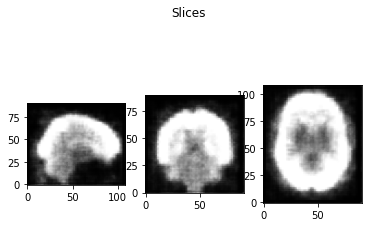

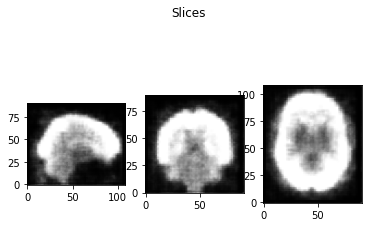

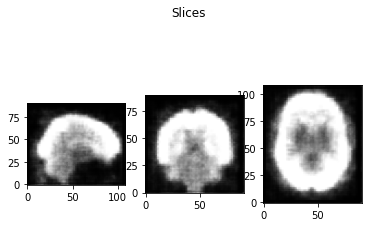

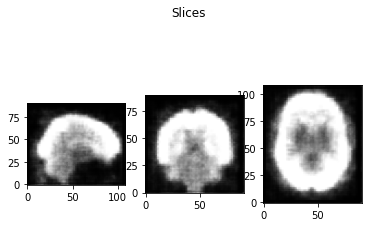

In [40]:
get_plot('try0.nii.gz')
get_plot('try1.nii.gz')
get_plot('try2.nii.gz')
get_plot('try3.nii.gz')

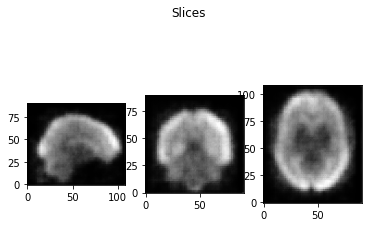

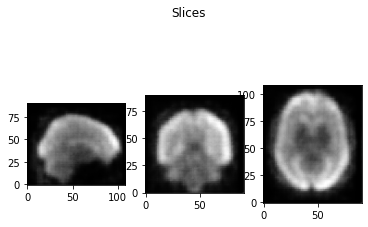

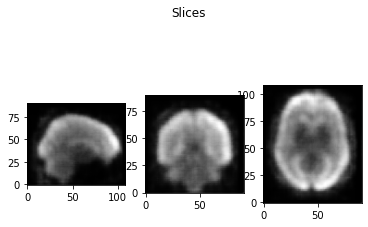

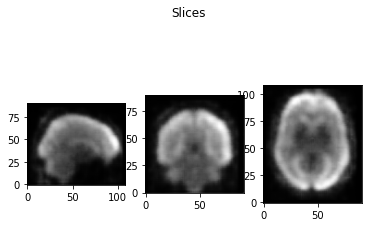

In [28]:
get_plot('newmodeltry0.nii.gz')
get_plot('newmodeltry0_1000epochs.nii.gz')
get_plot('newmodeltry0_1500epochs.nii.gz')
get_plot('newmodeltry0_2000epochs.nii.gz')

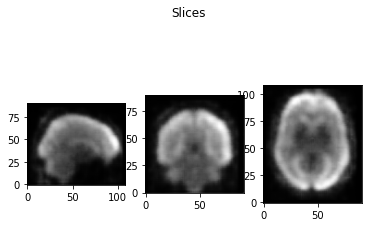

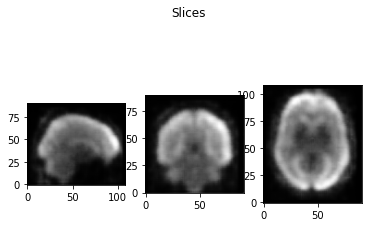

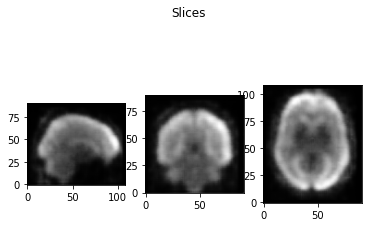

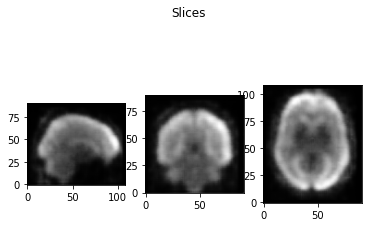

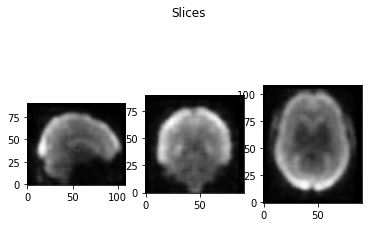

In [35]:
get_plot('newmodeltry0_2000epochs.nii.gz')
get_plot('newmodeltry1_2000epochs.nii.gz')
get_plot('newmodeltry2_2000epochs.nii.gz')
get_plot('newmodeltry3_2000epochs.nii.gz')
get_plot('newmodeltry3_2500epochs.nii.gz')

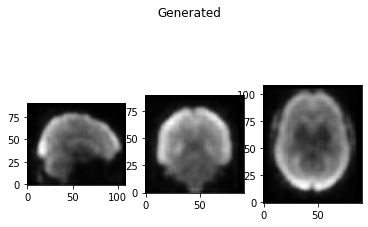

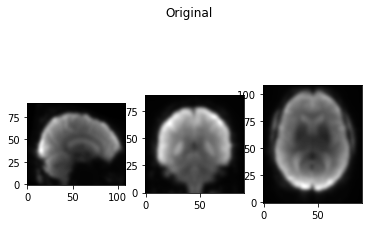

In [22]:
get_plot('newmodel_img0_2000epochs.nii.gz', plot_name = 'Generated')
get_plot('I269254_I989324imagedata.nii.gz', './Dataset', 'Original')

In [49]:
print(os.listdir(data_dir))

['I269254_I989324imagedata.nii.gz', 'I269254_I1304069imagedata.nii.gz', 'I269254_I1501115imagedata.nii.gz', 'I269254_I1241097imagedataLMCI.nii.gz', 'I269254_I235238imagedataLMCI.nii.gz', 'I269254_I1132801imagedata.nii.gz']


In [21]:
max_value

[tensor(2161., dtype=torch.float64),
 tensor(1921., dtype=torch.float64),
 tensor(1862., dtype=torch.float64),
 tensor(1572., dtype=torch.float64)]

The following can be ignored

In [15]:
h_new = torch.rand(1, 10)
h_new = to_device(h_new, device)
h_new

tensor([[0.2202, 0.6590, 0.7569, 0.2700, 0.8852, 0.1977, 0.5833, 0.0263, 0.1568,
         0.2667]], device='cuda:0')

In [28]:
h_new = torch.tensor([[1.1949, -0.6692,  0.2503,  0.0041, -2.3825,  0.6658, -0.0488, -0.7783,
          0.4877,  0.7172]])
h_new = to_device(h_new, device)
h_new

tensor([[ 1.1949, -0.6692,  0.2503,  0.0041, -2.3825,  0.6658, -0.0488, -0.7783,
          0.4877,  0.7172]], device='cuda:0')

In [29]:
dec_h_new = model.decode(h_new)
dec_h_new = dec_h_new.squeeze(0)
dec_h_new.shape

torch.Size([1, 91, 109, 91])

In [30]:
dec_h_new = torch.Tensor.cpu(dec_h_new)
dec_h_new = dec_h_new.detach().numpy()
dec_h_new.shape

(1, 91, 109, 91)

In [31]:
dec_h_new = dec_h_new * 1000 + 1000

In [32]:
img_new = nib.Nifti1Image(dec_h_new, np.eye(4))
nib.save(img_new, os.path.join('Generated', 'firstone.nii.gz'))  

Run one by one:

In [ ]:
epochs=0
lr=1e-5
opt_func=torch.optim.SGD
train_loss_history = []
optimizer = opt_func(model.parameters(), lr)

In [14]:
for batch in train_loader:
    debug_batch = batch
    break
debug_batch.shape

torch.Size([2, 1, 91, 109, 91, 177])

In [15]:
debug_batch = debug_batch.to(torch.float32)

In [20]:
x = debug_batch
tol_time = x.size(-1) # x is of size batch_size*channel*x1*x2*x3*tol_time
x_list = [x[:,:,:,:,:,t] for t in range(tol_time)]
h_history = []
gh_history = []
mu_history = []
t=0
h = h0.expand(batch.size(0), -1)

In [23]:
h

tensor([[0.7748, 0.9898, 0.8597, 0.2896, 0.6602, 0.5488, 0.3357, 0.4594, 0.9147,
         0.3443],
        [0.7748, 0.9898, 0.8597, 0.2896, 0.6602, 0.5488, 0.3357, 0.4594, 0.9147,
         0.3443]], device='cuda:0')

In [25]:
gh_history.append(model.g_transform(h))
gh_history

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
        grad_fn=<NativeBatchNormBackward0>),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
        grad_fn=<NativeBatchNormBackward0>),
 tensor([[-0.2693, -0.2893,  0.0075,  0.7103, -0.5138,  0.1778, -0.0302, -0.2398,
          -0.1408,  0.2811],
         [-0.2693, -0.2893,  0.0075,  0.7103, -0.5138,  0.1778, -0.0302, -0.2398,
          -0.1408,  0.2811]], device='cuda:0', grad_fn=<AddmmBackward0>)]